<a href="https://colab.research.google.com/github/Frey87/Google-Courses/blob/main/Cloud/Develop_and_Secure_APIs_with_Apigee_X_Challenge_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Develop and Secure APIs with Apigee X: Challenge Lab:**

> **Task 1:**

Confirm that the Cloud Translation API is enabled
Open Apigee UI - https://apigee.google.com/
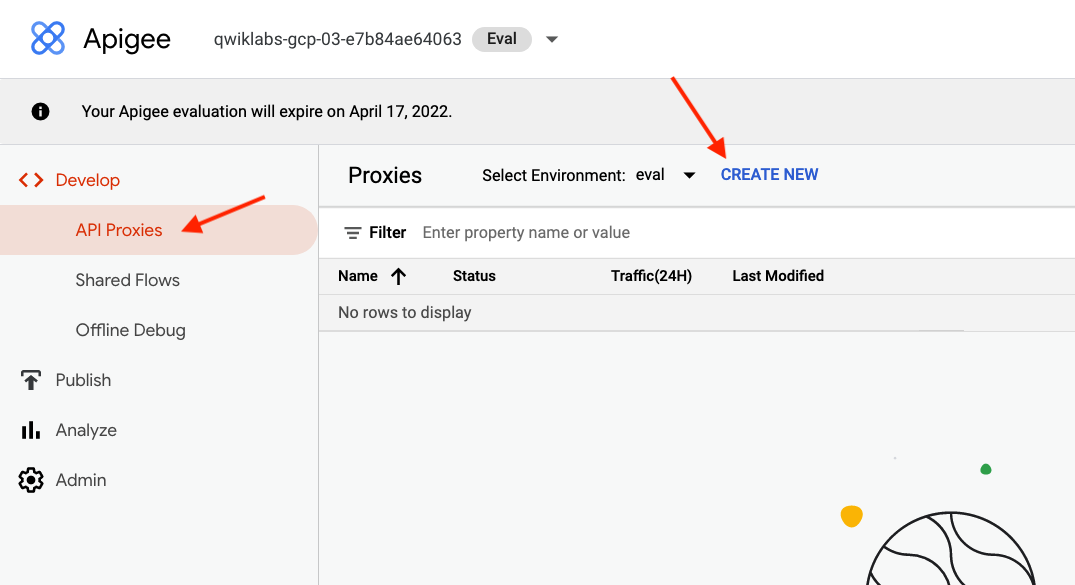
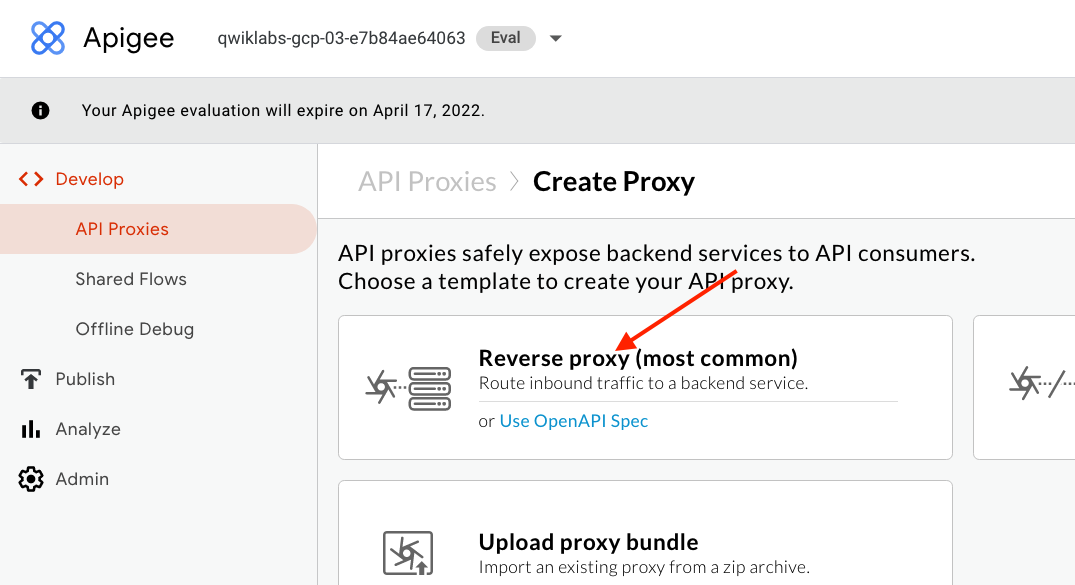

Enter the information as under:
* Name: translate-v1
* Base path: /translate/v1
* Target (Existing API): https://translation.googleapis.com/language/translate/v2
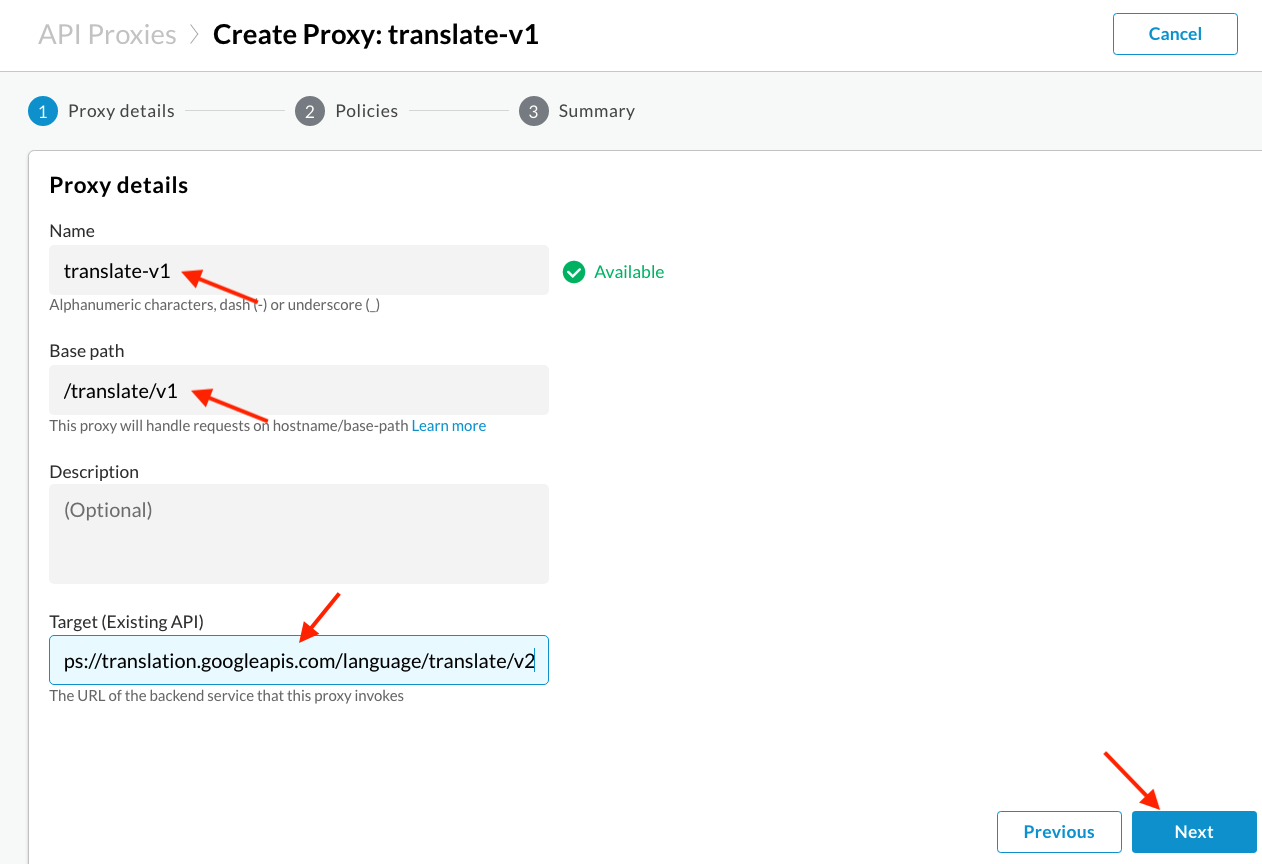
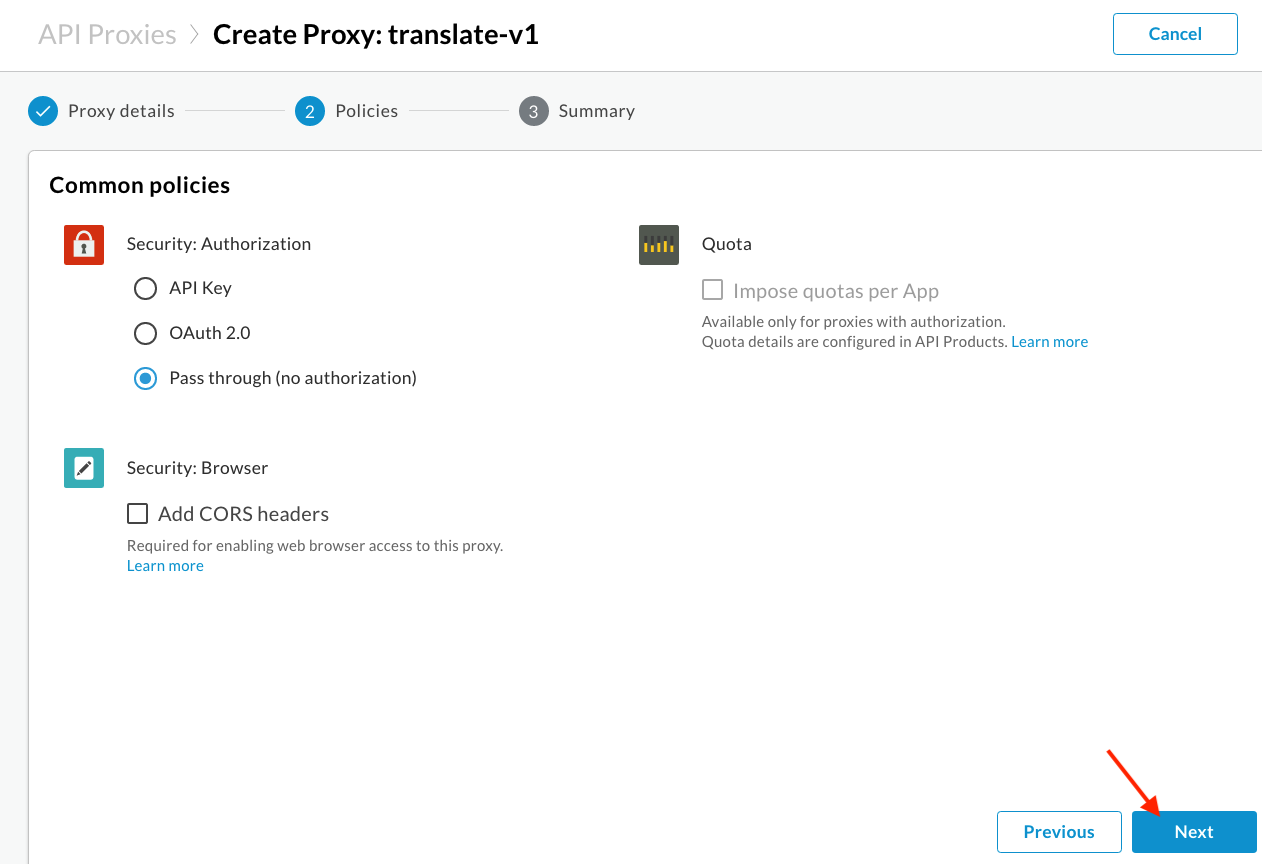
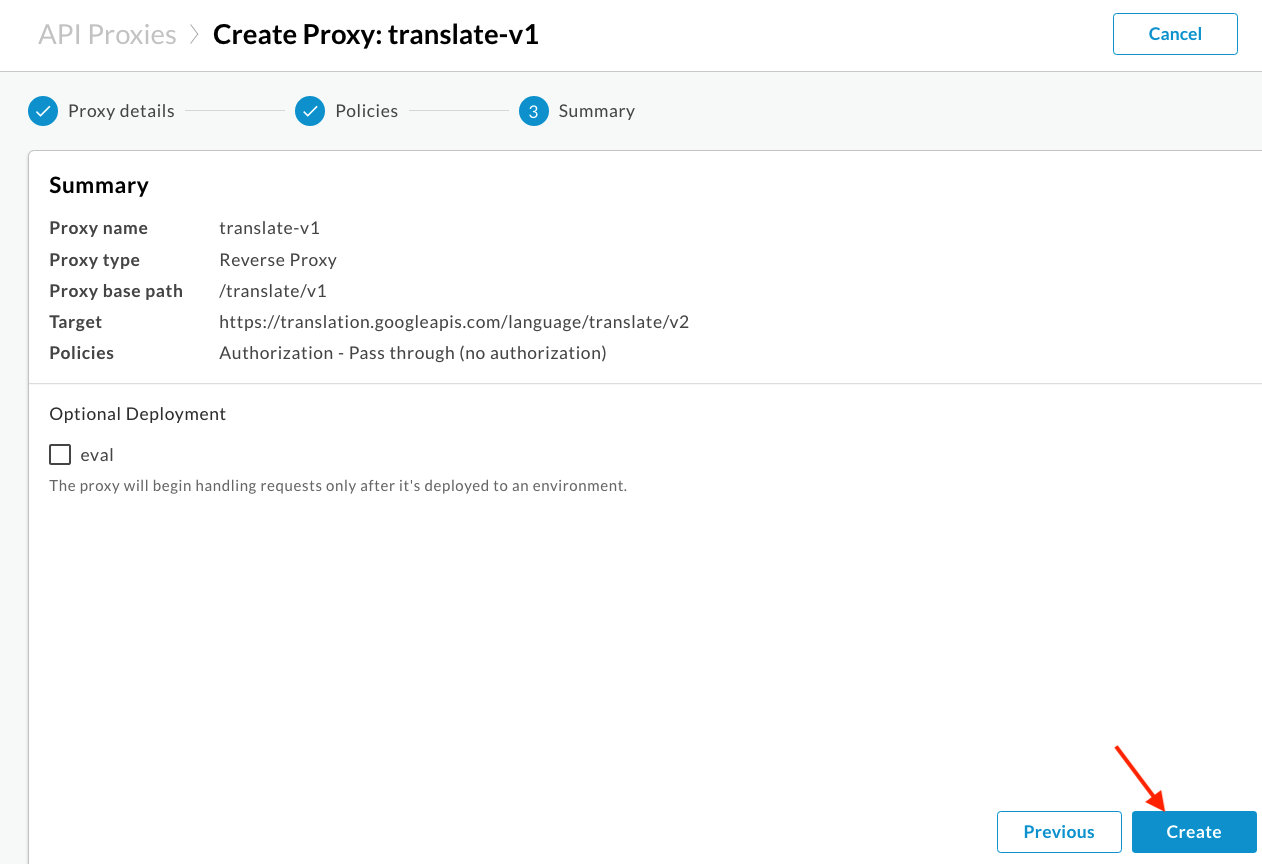


Now, create Service Account in Google Cloud Console
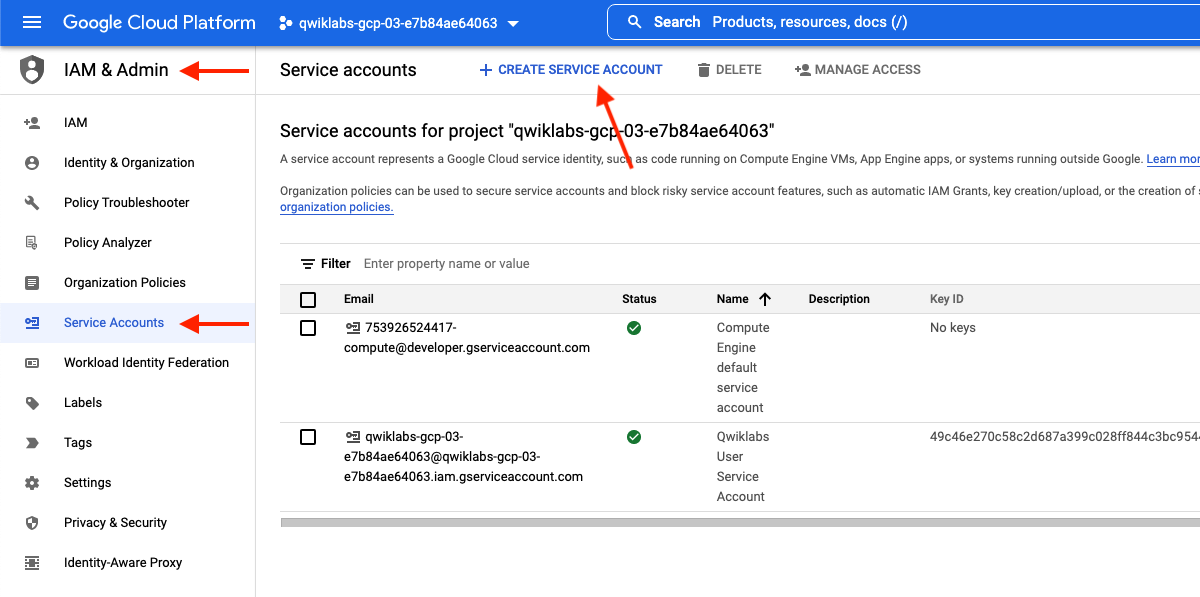
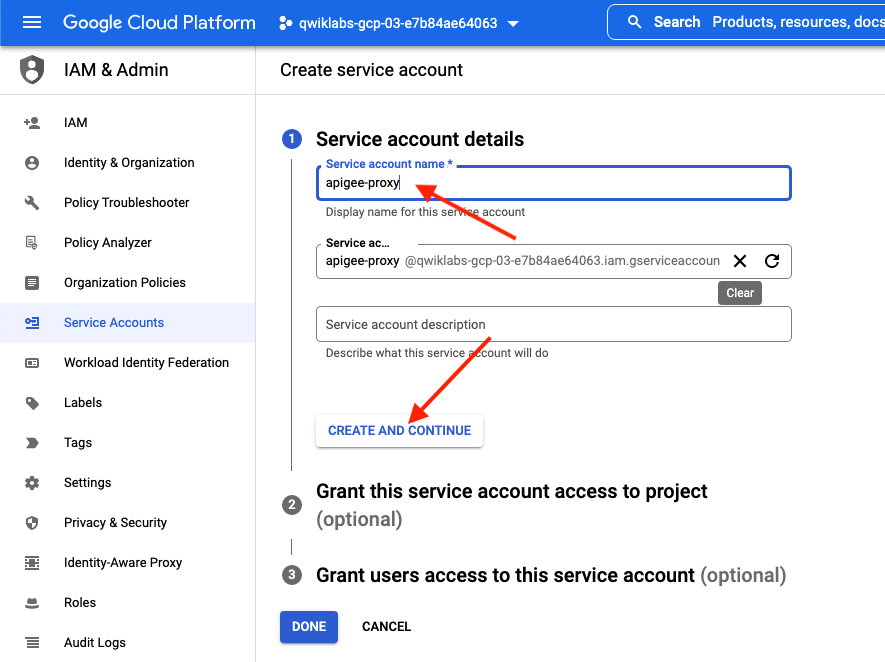
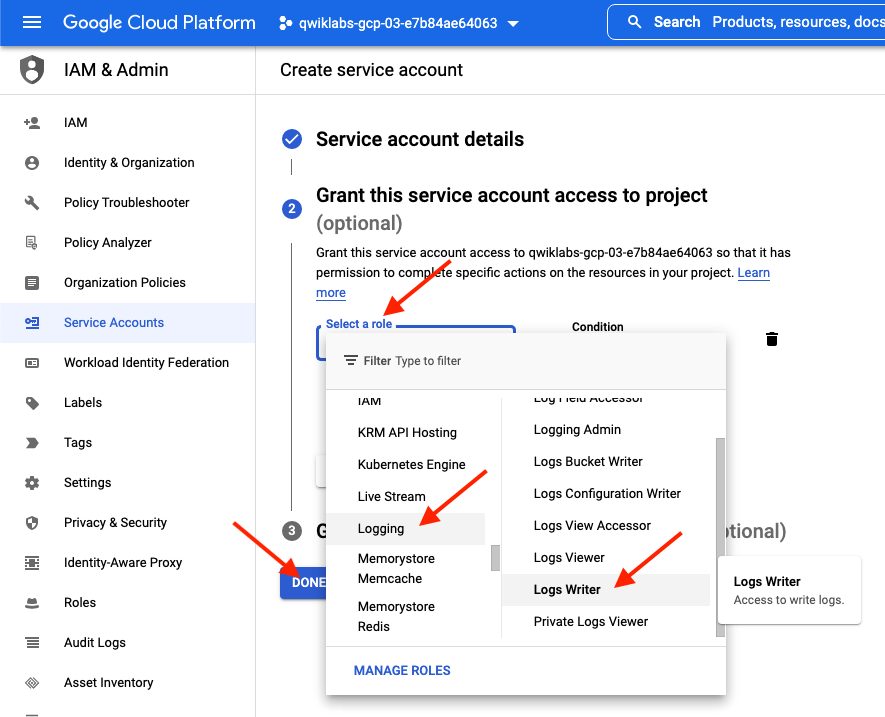
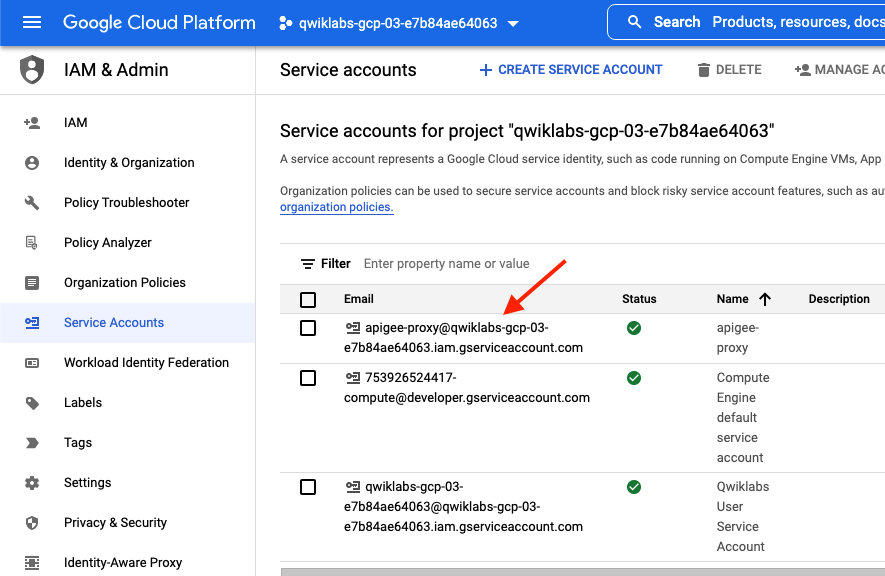

In Apigee UI:
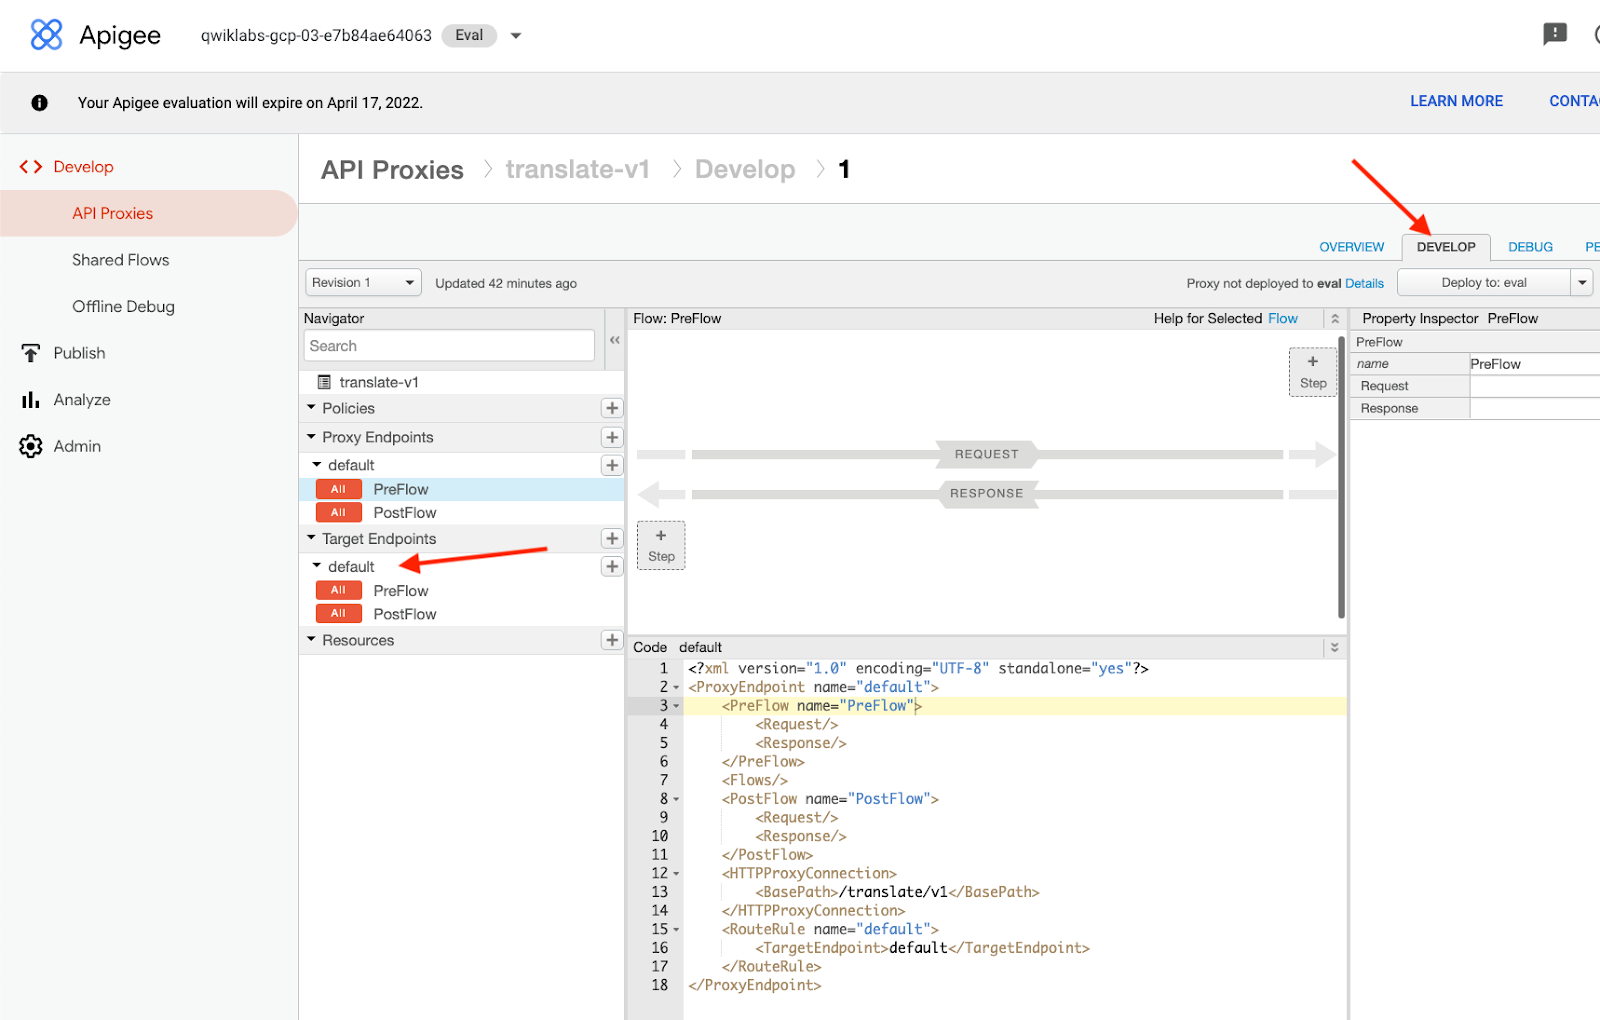

In API Proxies, add the below highlighted code in default.xml under Target Endpoints and click Save.

In [ ]:
<HTTPTargetConnection>
      <URL>https://translation.googleapis.com/language/translate/v2</URL>
      <Authentication>
          <GoogleAccessToken>
              <Scopes>
                  <Scope>https://www.googleapis.com/auth/cloud-translation</Scope>
              </Scopes>
          </GoogleAccessToken>
      </Authentication>
  </HTTPTargetConnection>

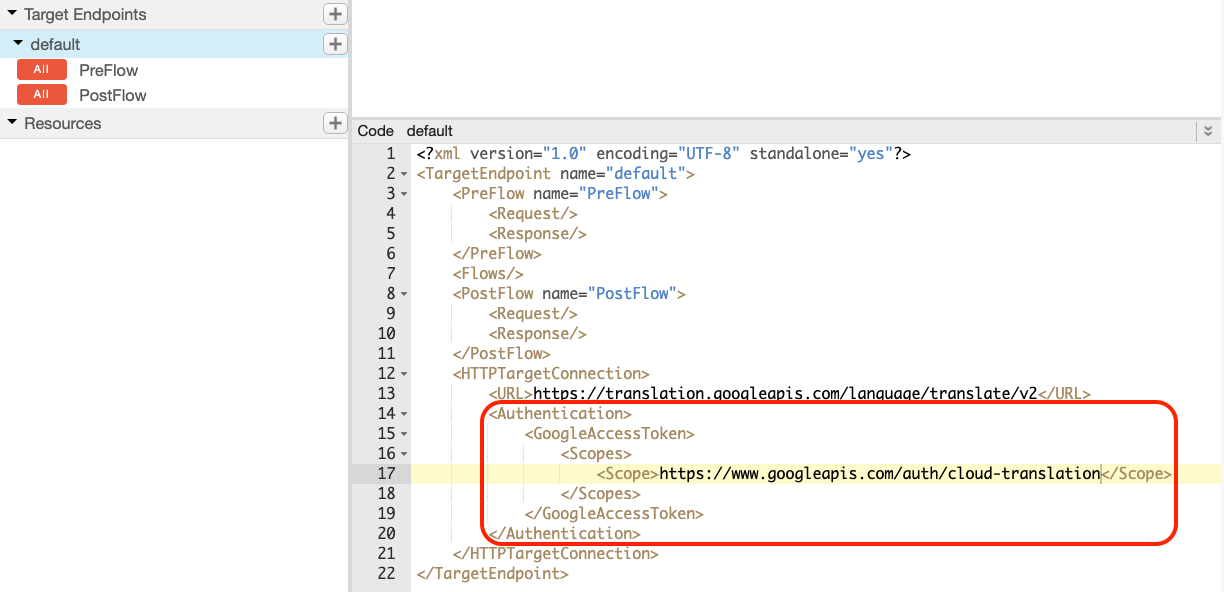
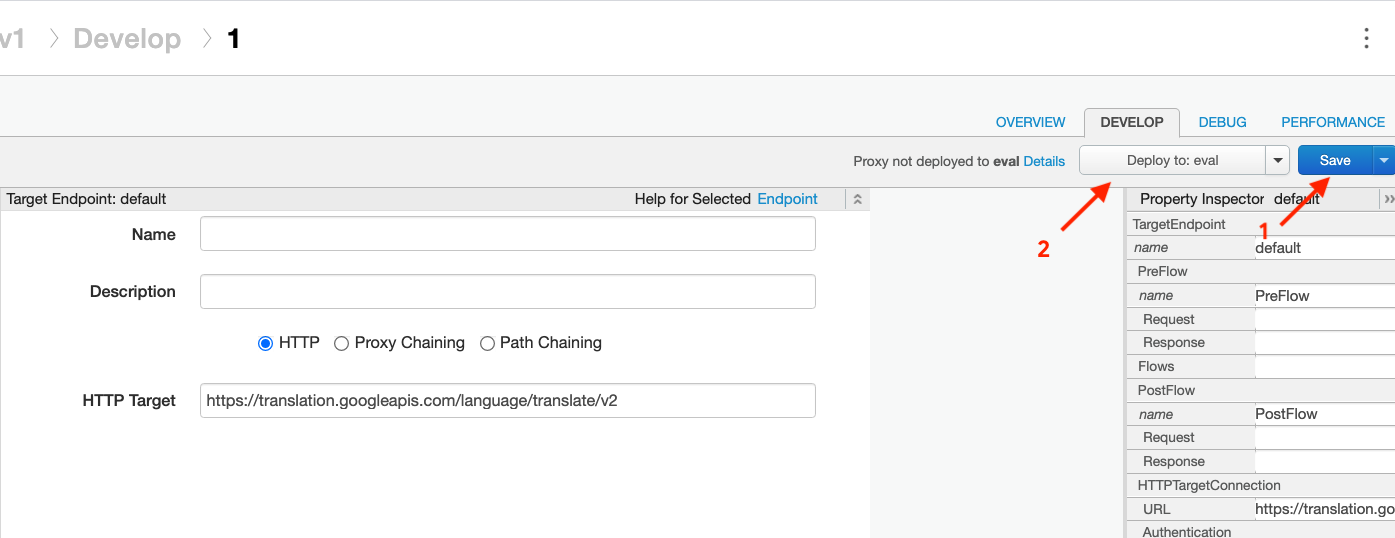

Click on Deploy, add any value to Revision, “eval” in Environment and copy the Service account ID.
Then click Deploy. Click Confirm.
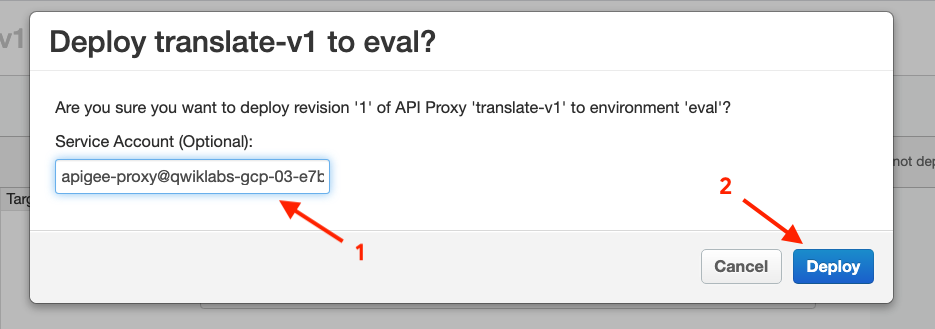

Use the following Cloud Shell script to confirm that the Apigee runtime is completely installed:

In [ ]:
export INSTANCE_NAME=eval-instance; export ENV_NAME=eval; export PREV_INSTANCE_STATE=; echo "waiting for runtime instance ${INSTANCE_NAME} to be active"; while : ; do export INSTANCE_STATE=$(curl -s -H "Authorization: Bearer $(gcloud auth print-access-token)" -X GET "https://apigee.googleapis.com/v1/organizations/${GOOGLE_CLOUD_PROJECT}/instances/${INSTANCE_NAME}" | jq "select(.state != null) | .state" --raw-output); [[ "${INSTANCE_STATE}" == "${PREV_INSTANCE_STATE}" ]] || (echo; echo "INSTANCE_STATE=${INSTANCE_STATE}"); export PREV_INSTANCE_STATE=${INSTANCE_STATE}; [[ "${INSTANCE_STATE}" != "ACTIVE" ]] || break; echo -n "."; sleep 5; done; echo; echo "instance created, waiting for environment ${ENV_NAME} to be attached to instance"; while : ; do export ATTACHMENT_DONE=$(curl -s -H "Authorization: Bearer $(gcloud auth print-access-token)" -X GET "https://apigee.googleapis.com/v1/organizations/${GOOGLE_CLOUD_PROJECT}/instances/${INSTANCE_NAME}/attachments" | jq "select(.attachments != null) | .attachments[] | select(.environment == \"${ENV_NAME}\") | .environment" --join-output); [[ "${ATTACHMENT_DONE}" != "${ENV_NAME}" ]] || break; echo -n "."; sleep 5; done; echo "***ORG IS READY TO USE***";



1.   In Cloud Shell, open an SSH connection to apigeex-test-vm using the commands as below



In [ ]:
TEST_VM_ZONE=$(gcloud compute instances list --filter="name=('apigeex-test-vm')" --format "value(zone)")
gcloud compute ssh apigeex-test-vm --zone=${TEST_VM_ZONE} --force-key-file-overwrite

2.   If asked to authorize, click Authorize. For each question asked in the gcloud command, click Enter or Return to specify the default input.

3.   Enter the following curl command should translate the text:

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1" -H "Content-Type: application/json" -d '{ "q": "Translate this text!", "target": "es" }'


> **Task 2**

In Apigee, create a new Resource
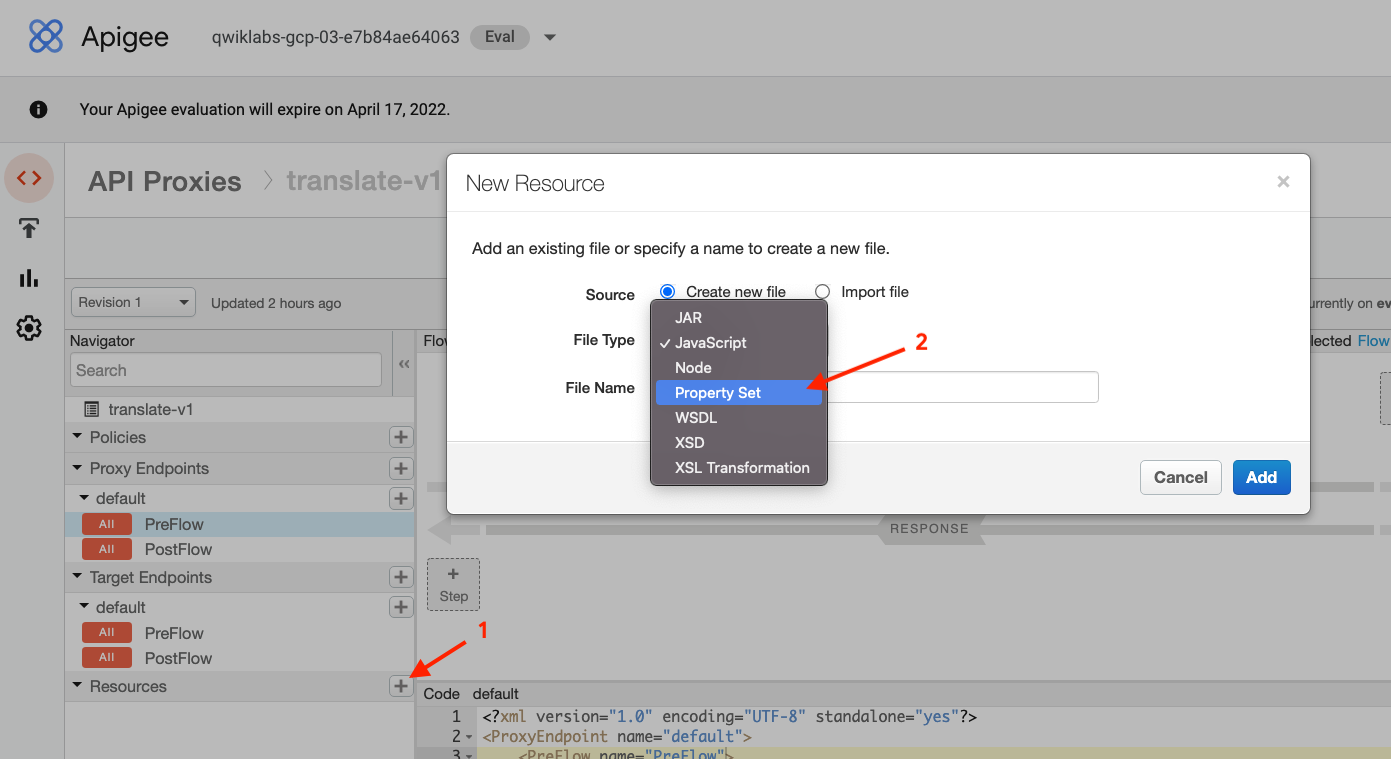

Choose Resource type as Property Set and put Resource Name as language.properties -> Add
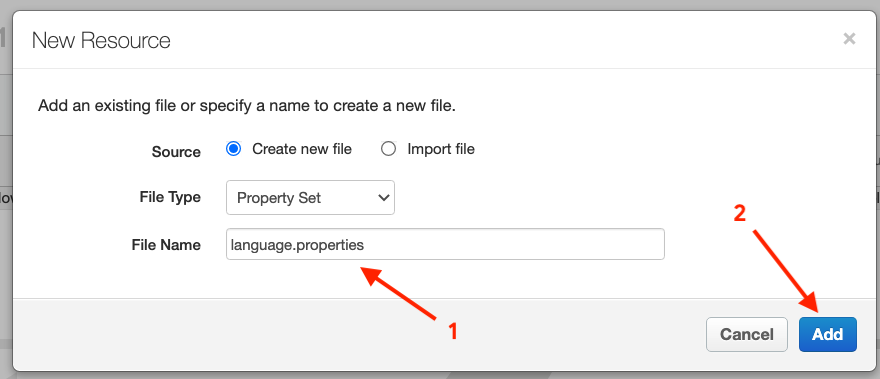
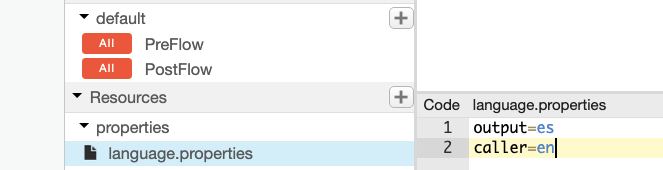

Add the following statements in language.properties and Save -> Save as new revision.
output=es
caller=en

Add conditional flow by clicking on ‘+’ symbol under Proxy Endpoint: default as in the screenshot below:
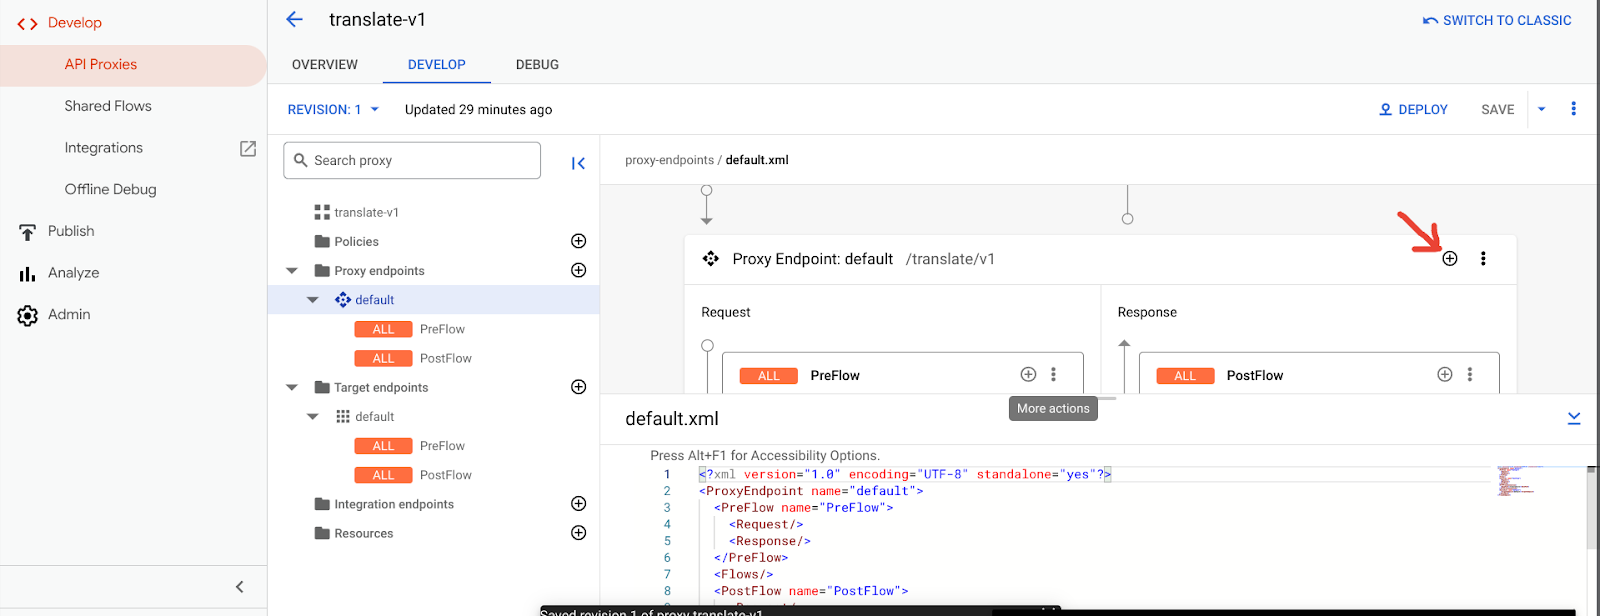
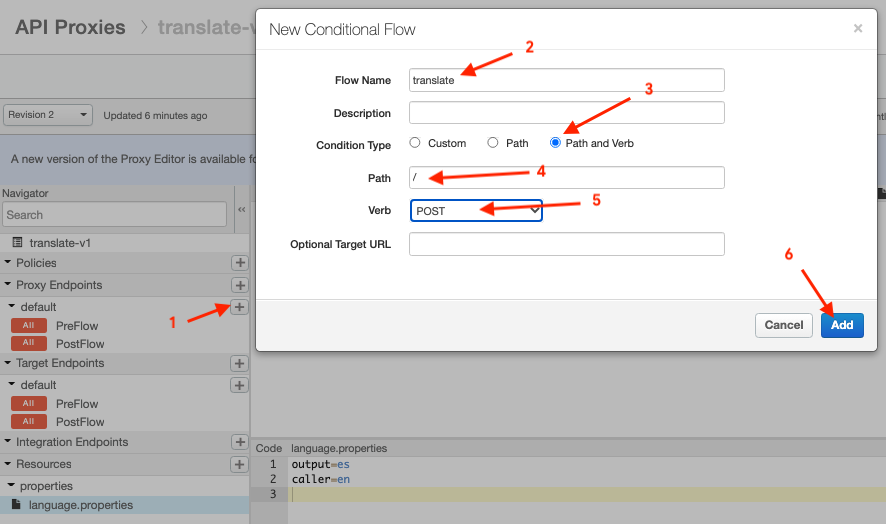

Add another conditional flow by clicking on ‘+’ symbol under Proxy Endpoint: default and fill in the details as in the screenshot below:
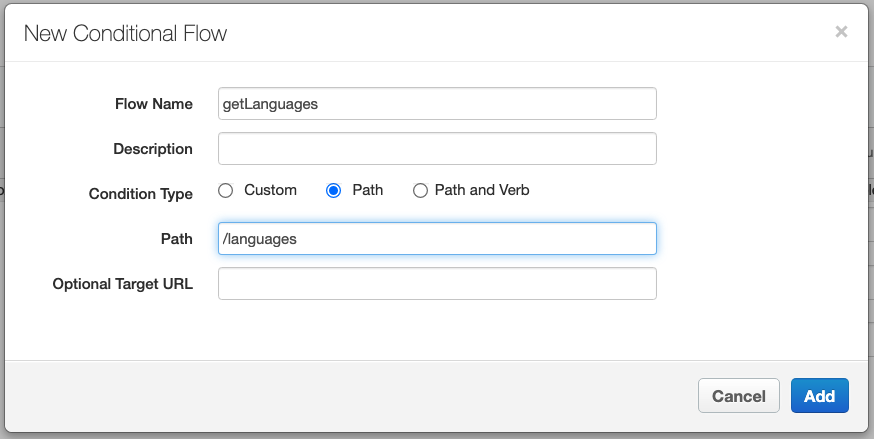

Refer the screenshot below to Add Policy Step in translate (Request PreFlow) by clicking on ‘+’
Click Select policy > Create New Policy
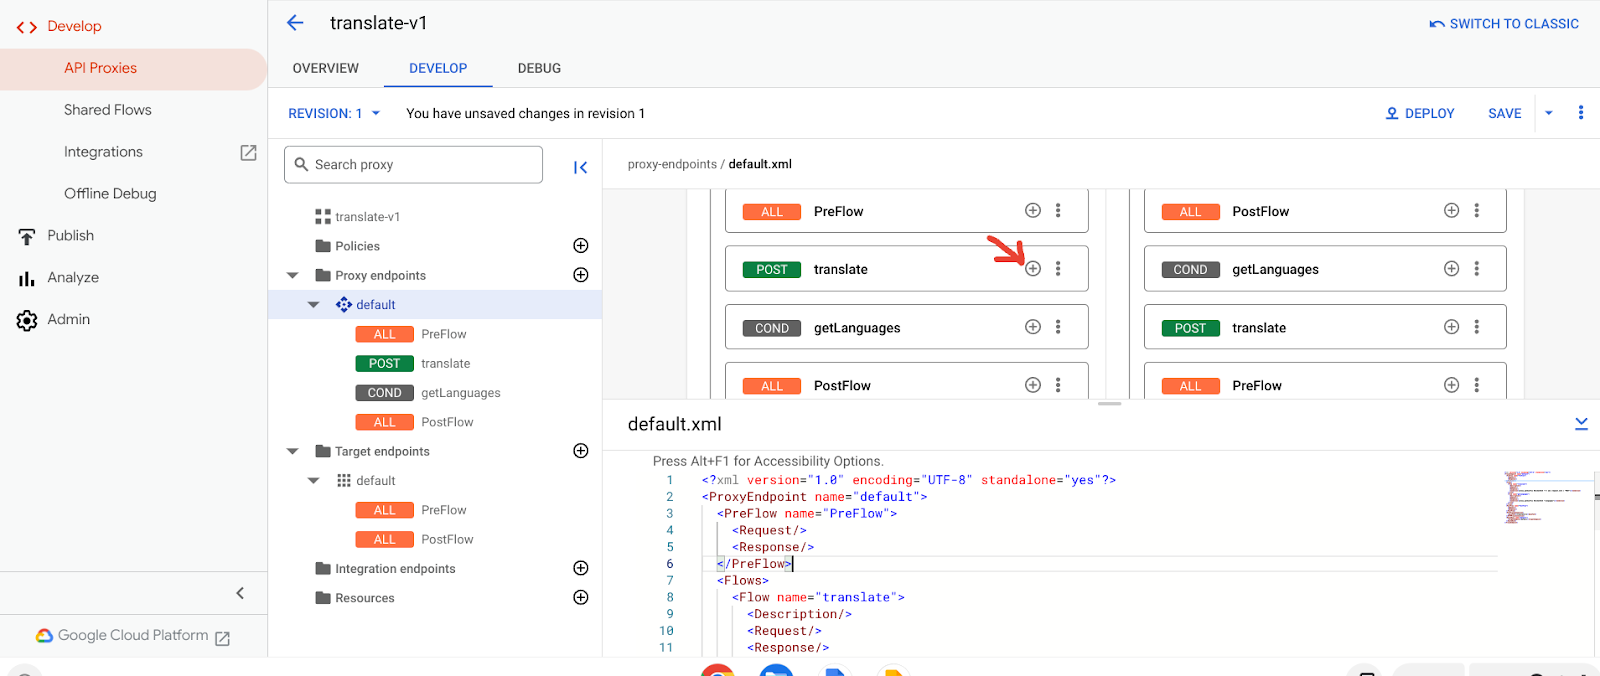

Choose Assign Message in policy type.
(We will add the following policy steps in translate: BuildTranslateRequest and BuildTranslateResponse)
Put AM-BuildTranslateRequest in Name and Display Name.
Click Create -> Select AM-BuildTranslateRequest -> Add
Again click on Add Policy Step (+) in translate (Request PreFlow) > Create New Policy > Assign Message in Policy type > add Name and Display name as AM-BuildTranslateResponse>Create > Select AM-BuildTranslateResponse>Add
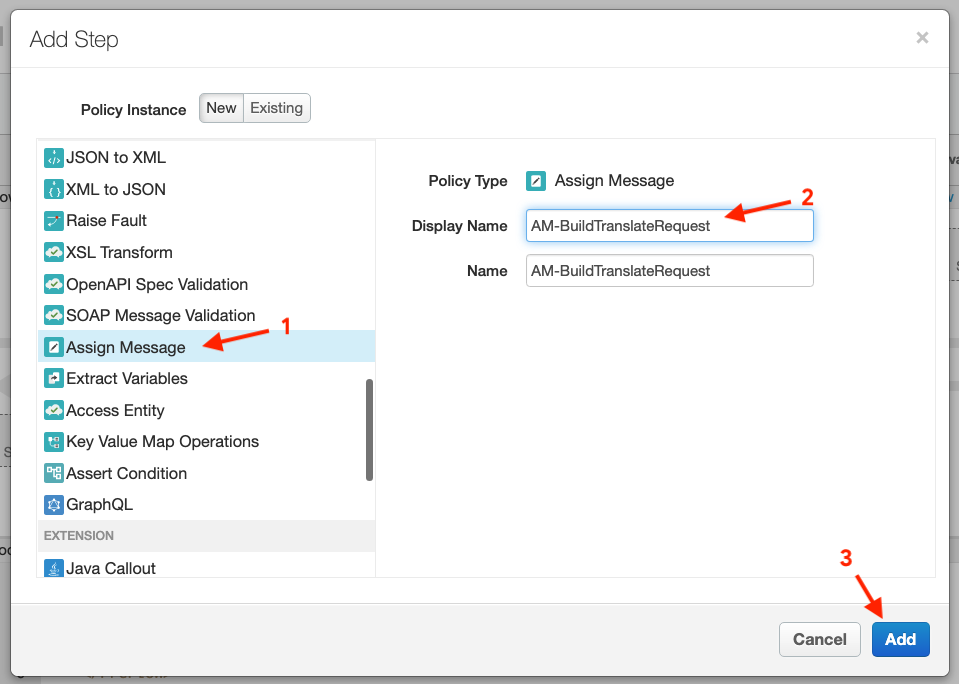

Your UI should look similar to the image below:
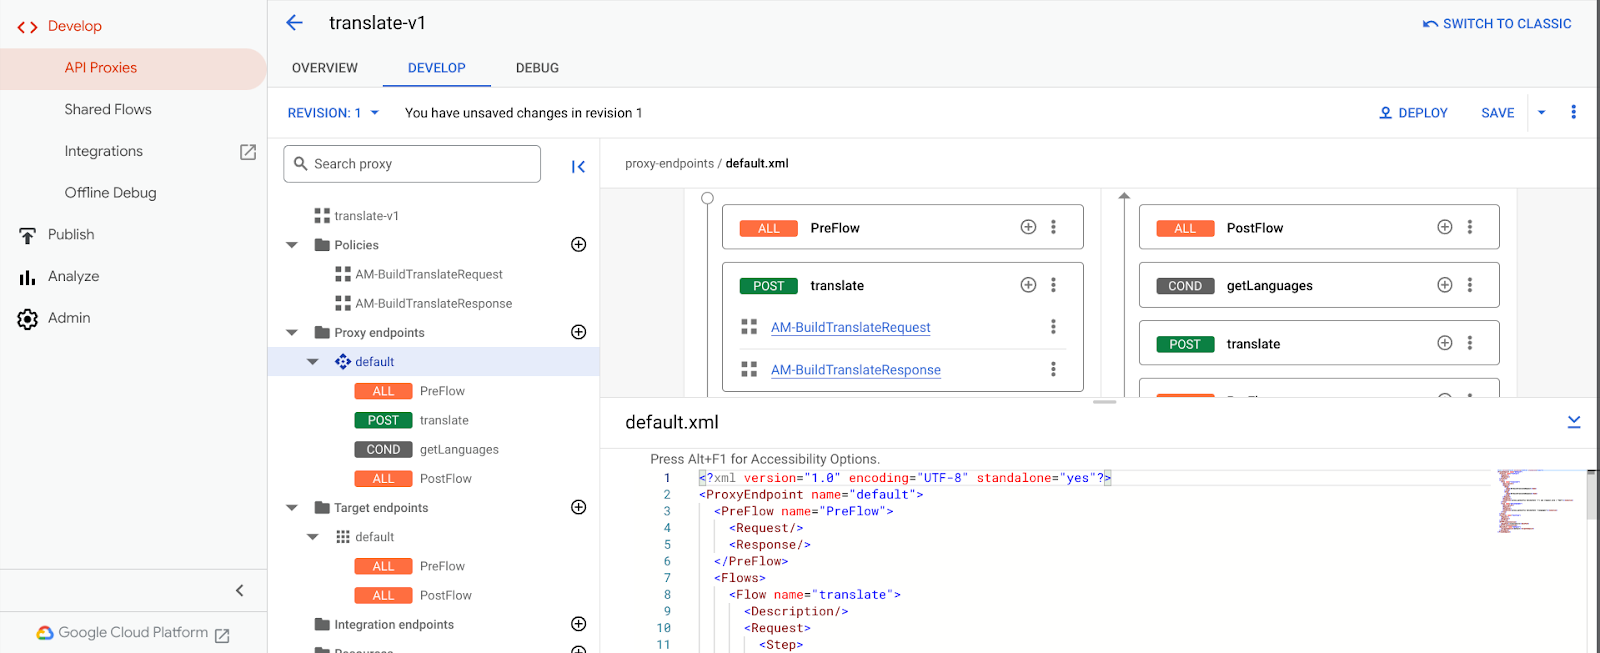

Click on AM-BuildTranslateRequest.xml and replace with the code below and click Save.
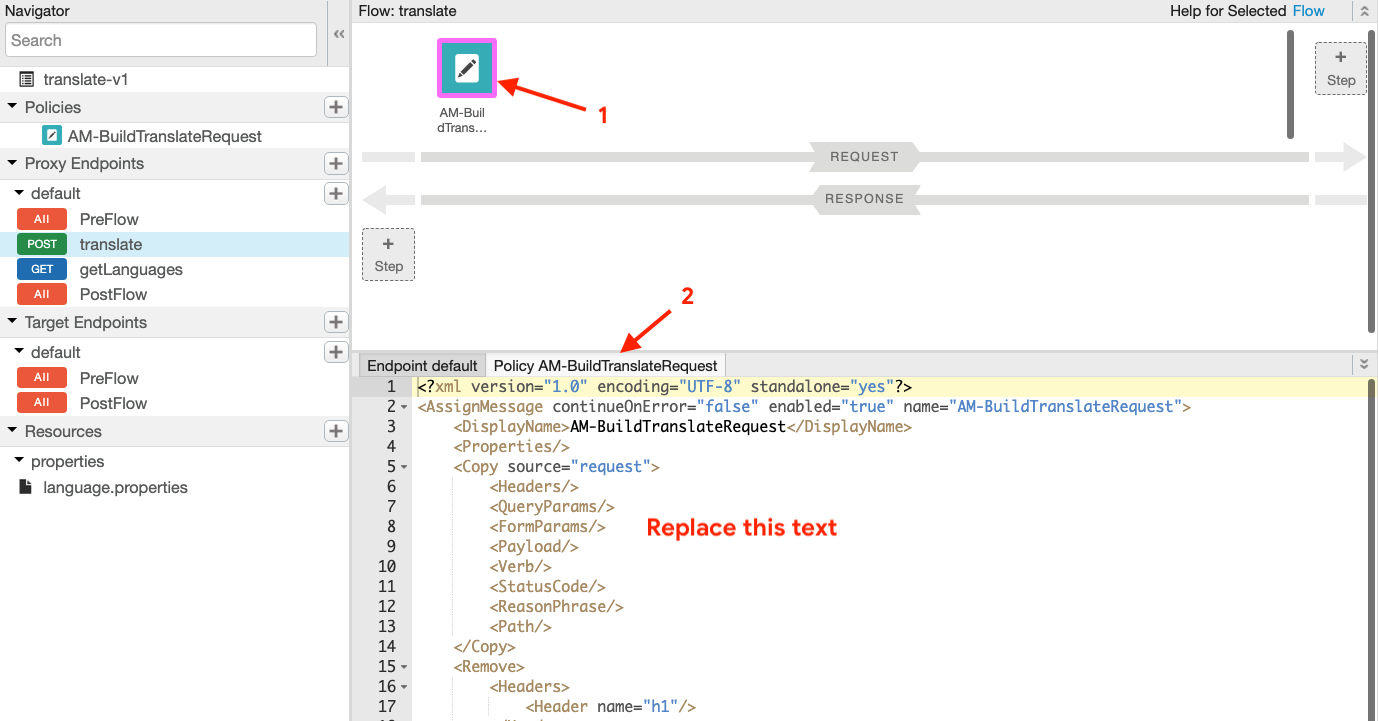

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<AssignMessage name="AM-BuildTranslateRequest">
  <AssignVariable>
      <Name>text</Name>
      <Template>{jsonPath($.text,request.content)}</Template>
  </AssignVariable>
  <AssignVariable>
      <Name>language</Name>
      <Template>{firstnonnull(request.queryparam.lang,propertyset.language.output)}</Template>
  </AssignVariable>
  <Set>
      <Payload>{ "q": "{text}", "target": "{language}" }</Payload>
  </Set>
  <IgnoreUnresolvedVariables>true</IgnoreUnresolvedVariables>
  <AssignTo createNew="false" transport="http" type="request"/>
</AssignMessage>

Similarly, click on AM-BuildTranslateResponse.xml, replace with the code below and click Save.

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<AssignMessage name="AM-BuildTranslateResponse">
  <AssignVariable>
      <Name>translated</Name>
      <Template>{jsonPath($.data.translations[0].translatedText,response.content)}</Template>
  </AssignVariable>
  <Set>
      <Headers>
          <Header name="Content-Type">application/json</Header>
      </Headers>
      <Payload>{"translated": "{translated}" }</Payload>
  </Set>
  <IgnoreUnresolvedVariables>true</IgnoreUnresolvedVariables>
  <AssignTo createNew="true" transport="http" type="response"/>
</AssignMessage>

Again click on Add Policy Step (+) in getLanguages (Request PreFlow) > click Select policy > Create New Policy > Assign Message in Policy type > add Name and Display name as AM-BuildLanguagesRequest >Create > select AM-BuildLanguagesRequest > Add

Similarly, Click on AM-BuildLanguagesRequest.xml, replace with the code below and Save.

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<AssignMessage name="AM-BuildLanguagesRequest">
  <Set>
      <Verb>POST</Verb>
      <Payload contentType="application/json">{ "target": "{propertyset.language.caller}" }</Payload>
  </Set>
  <IgnoreUnresolvedVariables>true</IgnoreUnresolvedVariables>
  <AssignTo createNew="true" transport="http" type="request"/>
</AssignMessage>

Again click on Add Policy Step (+) in getLanguages (Request PreFlow) > click Select policy >  Create New Policy > Javascript in Policy type > add Name and Display name as JS-BuildLanguagesResponse.

Click JavaScript file > Create New Resource

For Resource type, choose Javascript > for Source choose Create new file
For Resource name, type buildLanguagesResponse.js > Add > Create > select JS-BuildLanguagesResponse > Add
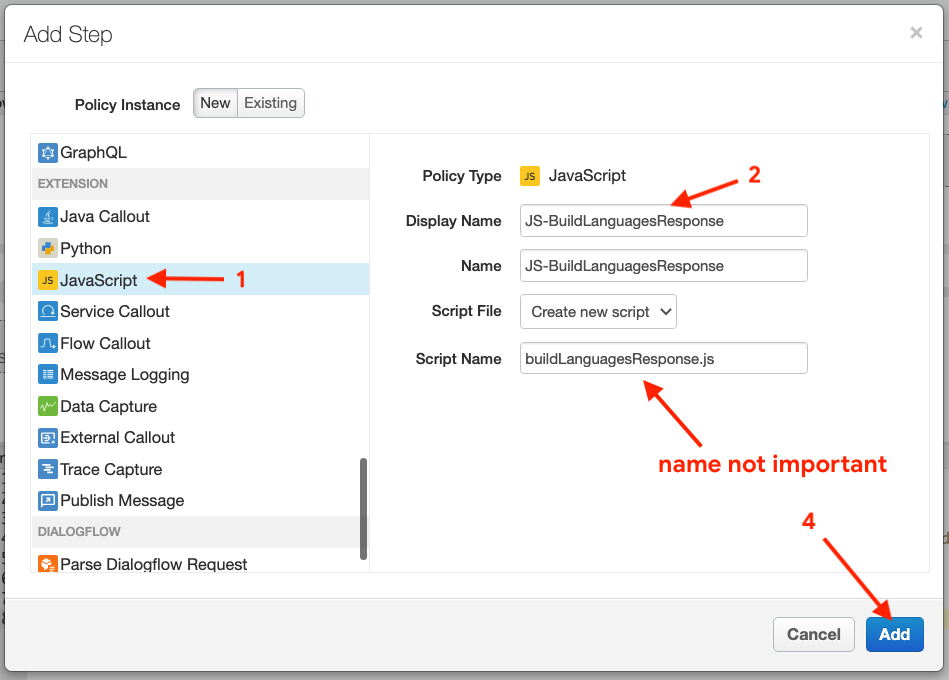

In JS-BuildLanguagesResponse.xml, replace with the code below and Save:

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<Javascript continueOnError="false" enabled="true" timeLimit="200" name="JS-BuildLanguagesResponse">
  <ResourceURL>jsc://buildLanguagesResponse.js</ResourceURL>
</Javascript>

On the left pane, under Resources > jsc > buildLanguagesResponse.js, add the below code and Save:

In [ ]:
var payload = context.getVariable("response.content");
var payloadObj = JSON.parse(payload);
var newPayload = JSON.stringify(payloadObj.data.languages);
context.setVariable("response.content", newPayload);

Click Deploy > add Revision value > Environment as eval and add the Service Account ID > Deploy > Confirm
After deployment succeeds, from the apigeex-test-vm virtual machine, use the following curl commands to test the examples shown below:
List of languages:

In [ ]:
curl -i -k -X GET "https://eval.example.com/translate/v1/languages"
Translate to specified language (German):
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=de" -H "Content-Type:application/json" -d '{ "text": "Hello world!" }'
Translate to default language (Spanish):
curl -i -k -X POST "https://eval.example.com/translate/v1" -H "Content-Type:application/json" -d '{ "text": "Hello world!" }'


> **Task 3**

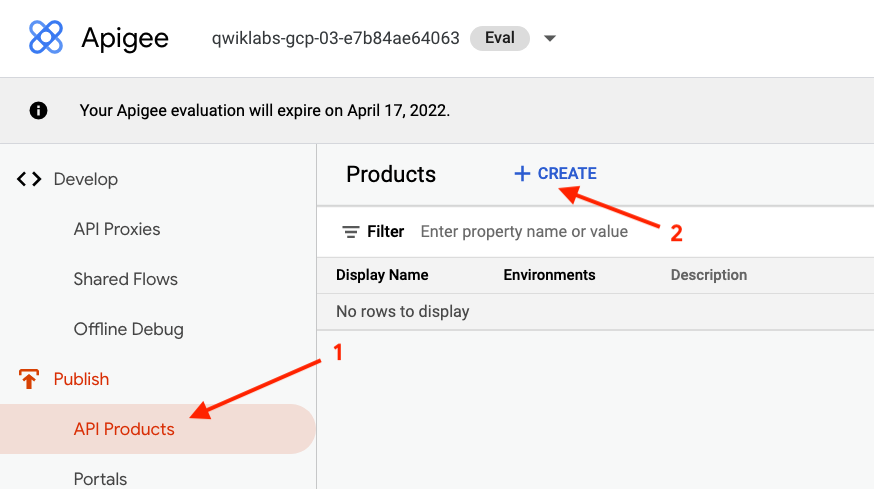
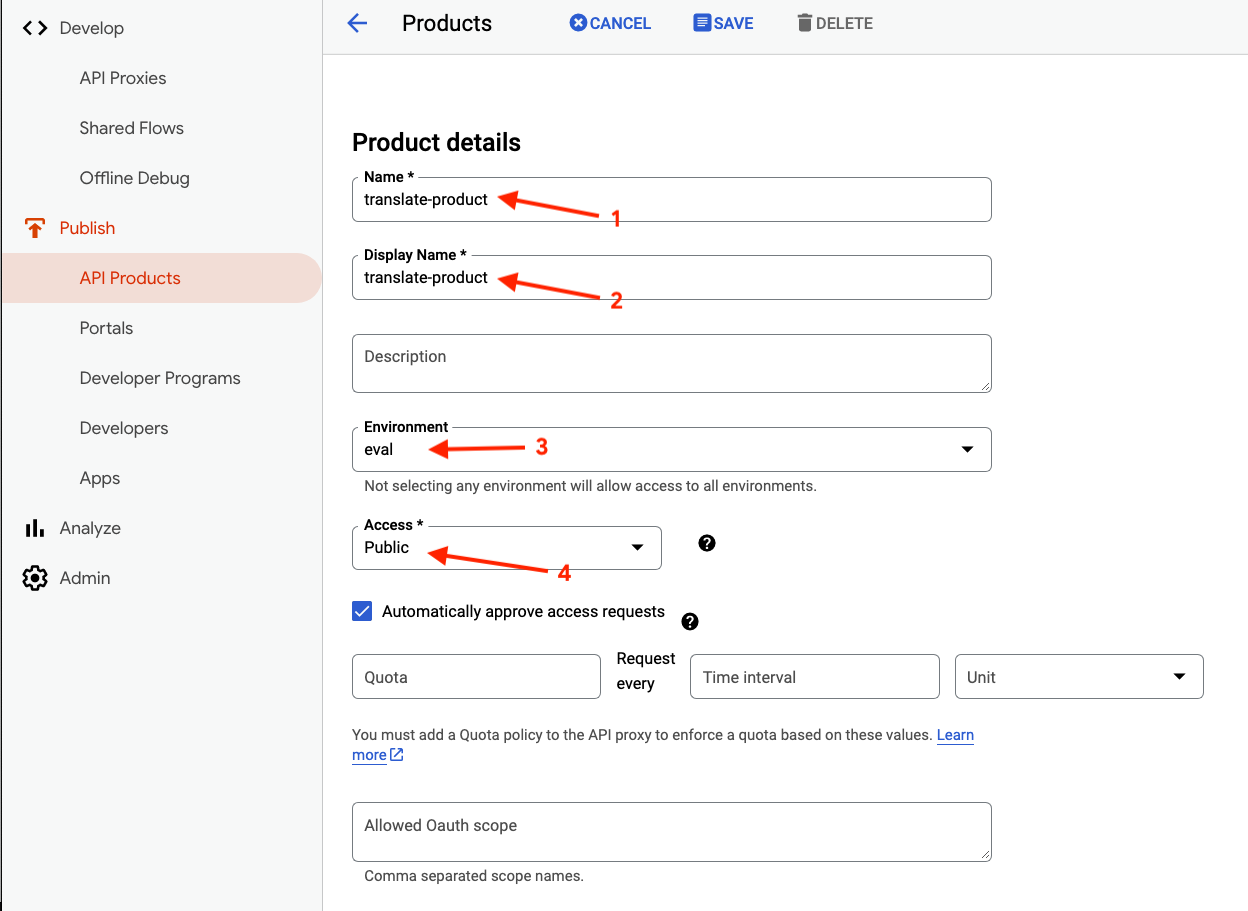
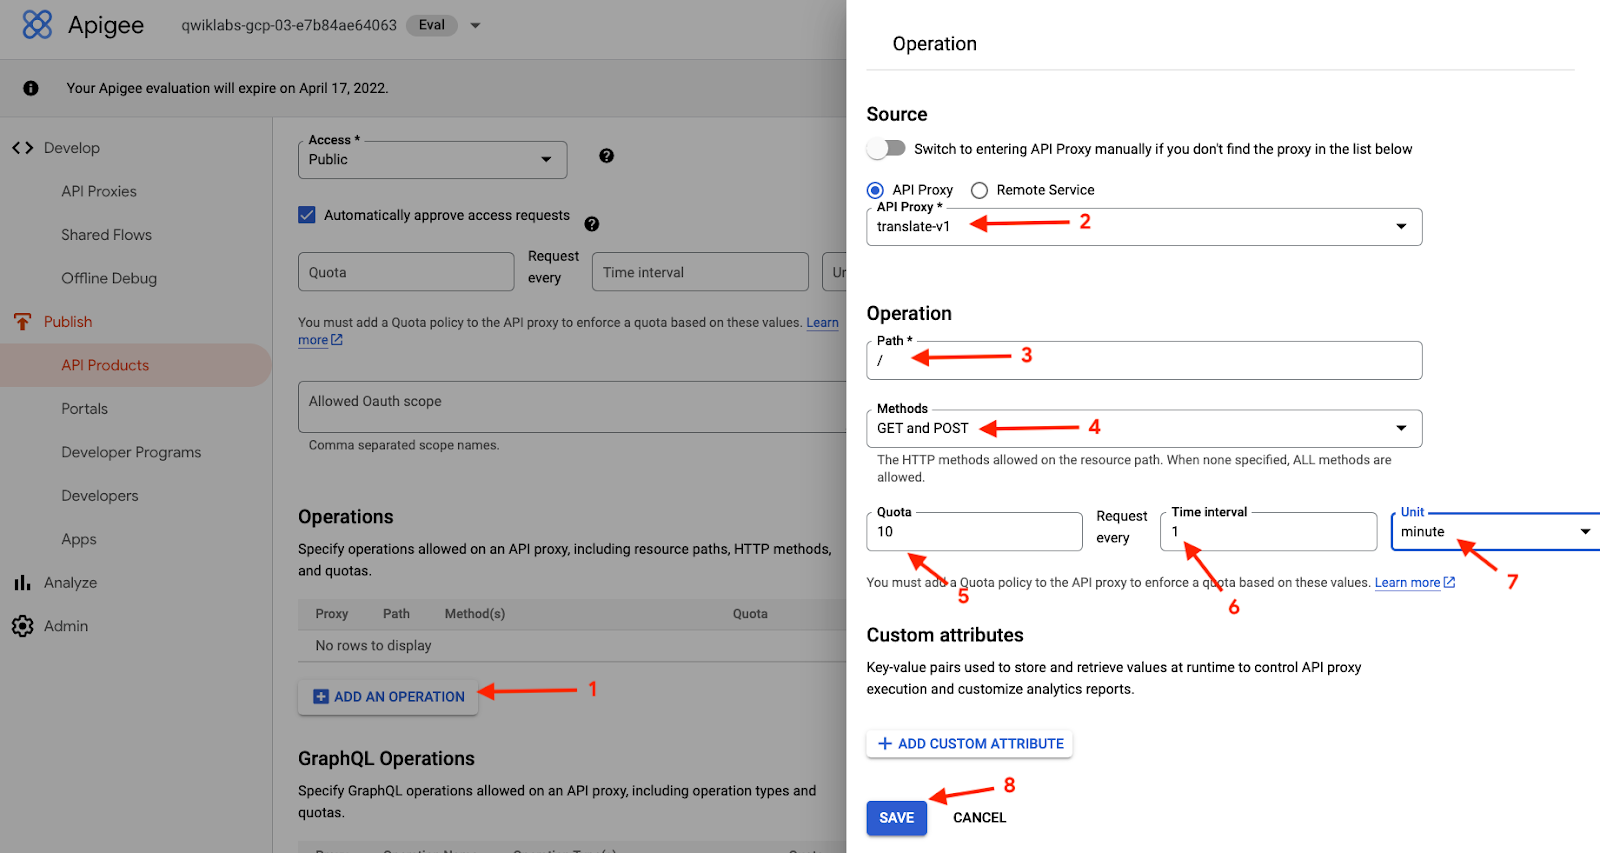
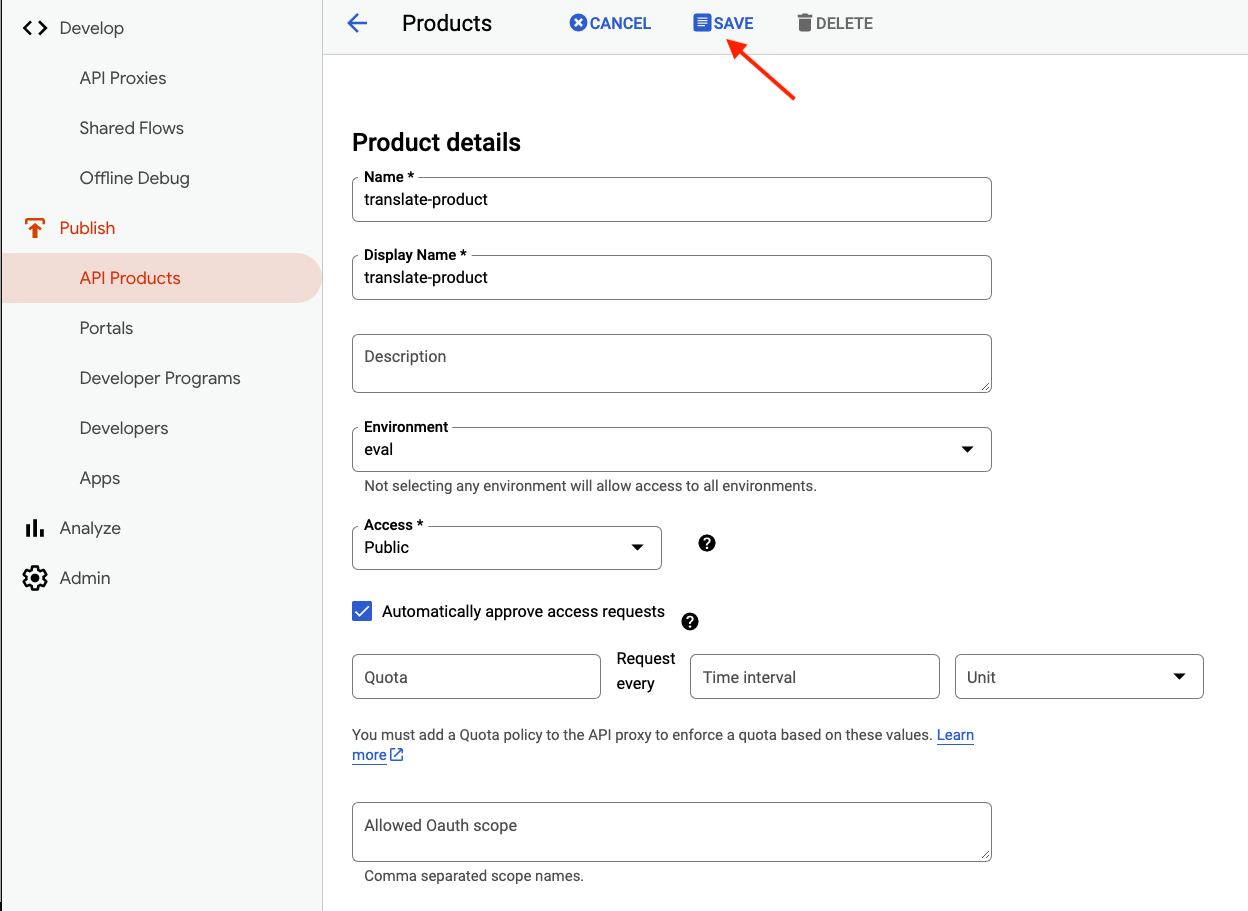

Click on Developers -> Add -> add Developer details as in the screenshot below and save
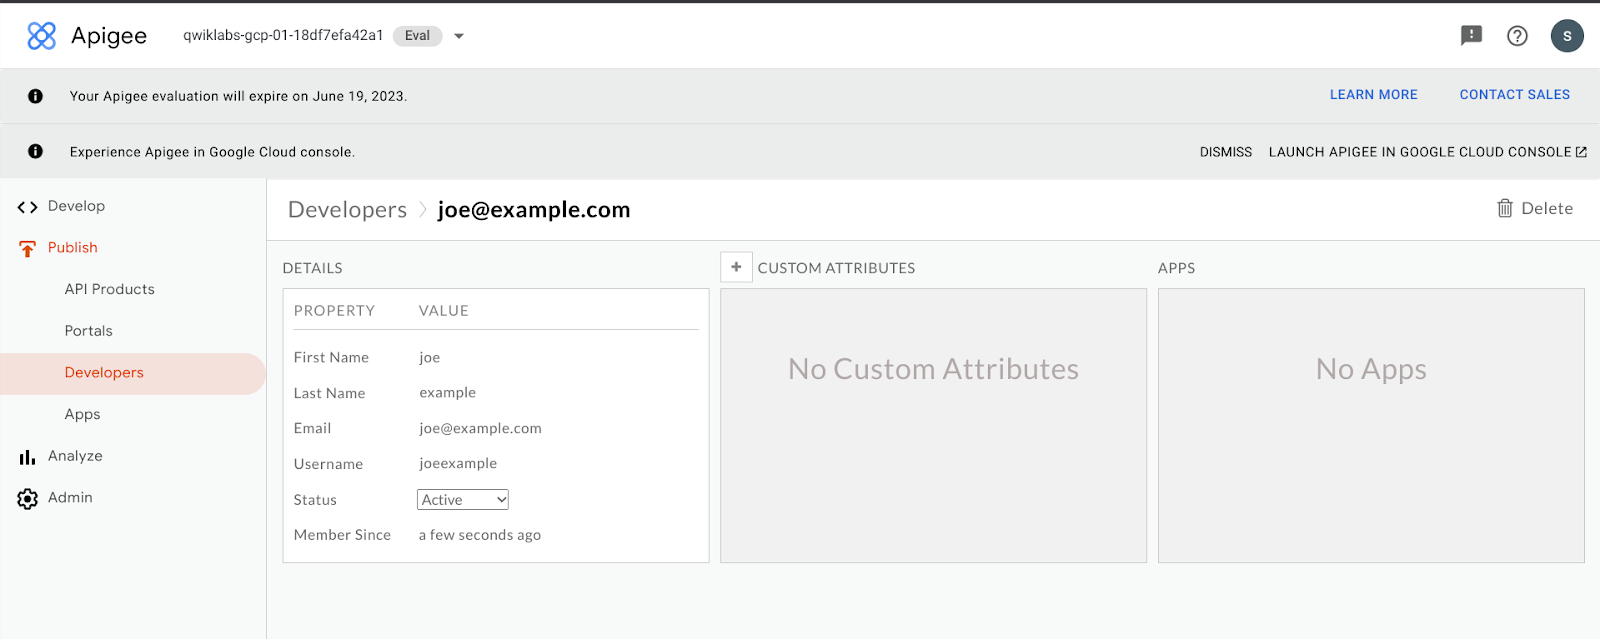
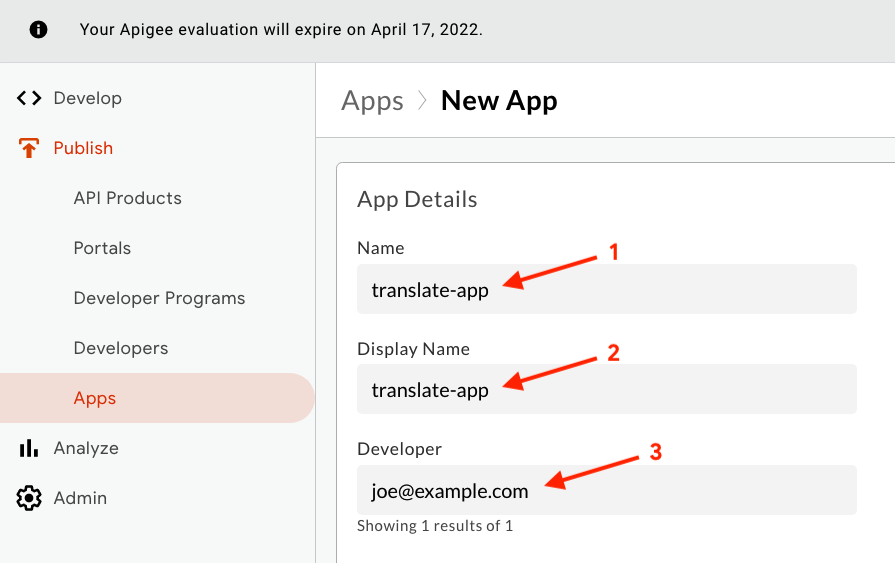
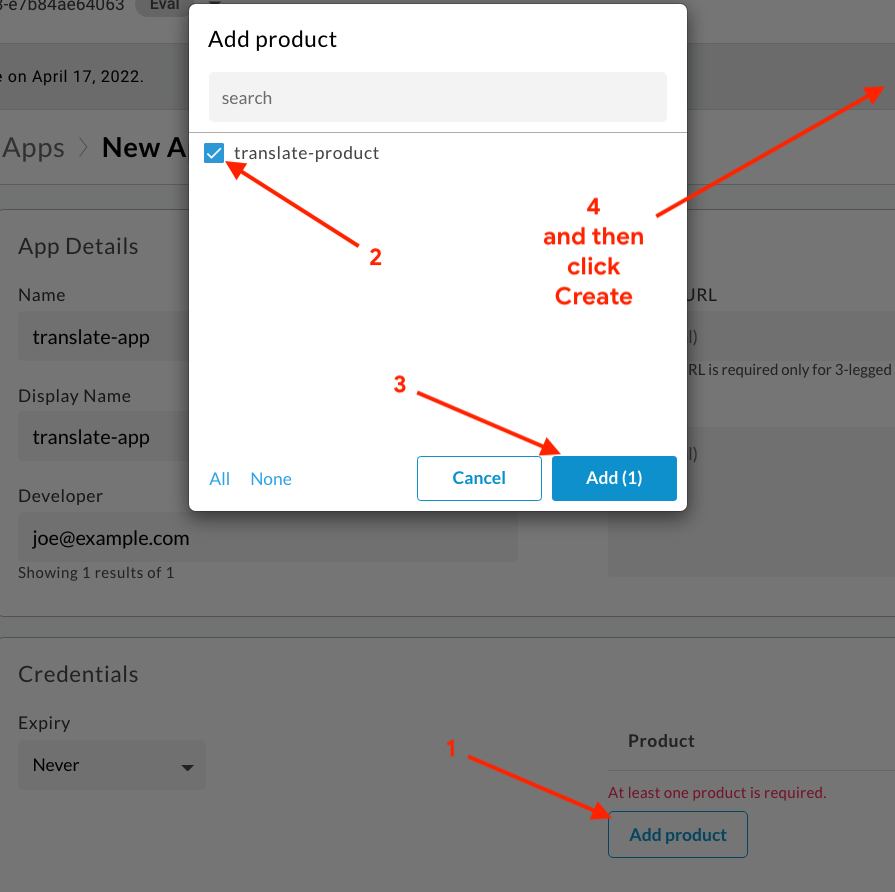

Now, click Develop on the left pane > choose API Proxies > translate-v1 > click on Develop tab
In Proxy endpoints > under Preflow (Request) > Add Policy Step
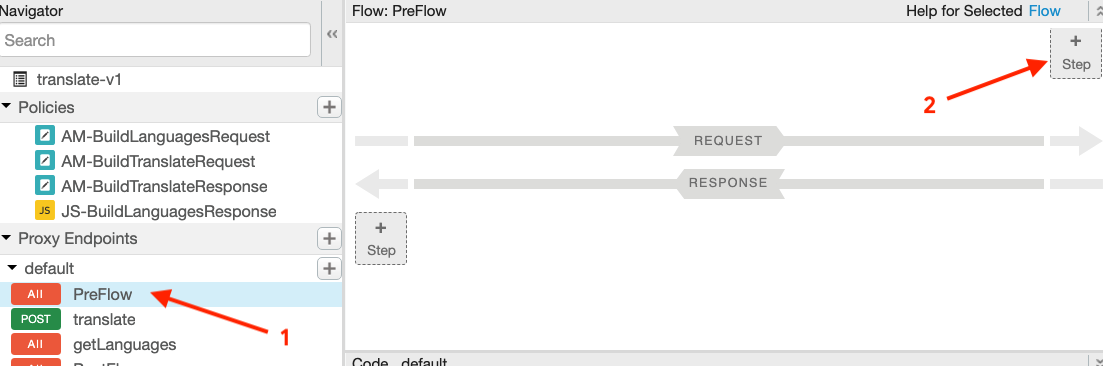

Click Select policy > Create new policy > Verify API Key > enter Name and Display Name as VAK-VerifyKey > Create
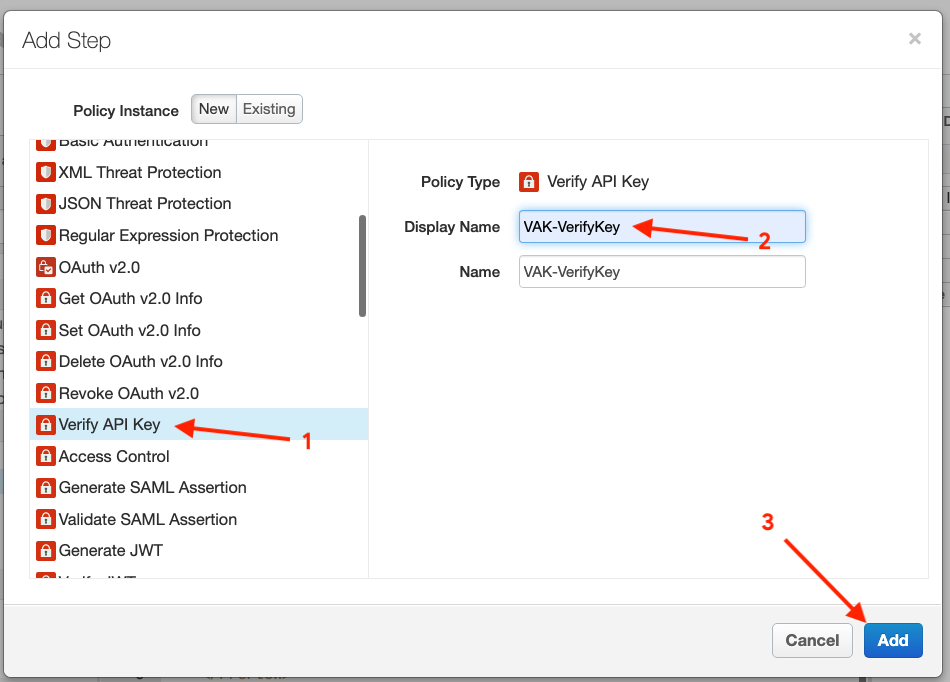

Then select VAK-VerifyKey > Add

Then in VAK-VerifyKey.xml, change the code as in the screenshot below and Save:
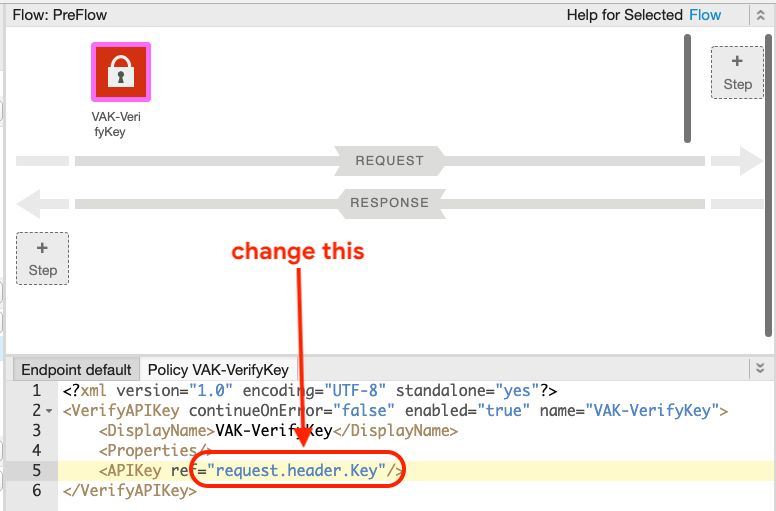

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<VerifyAPIKey continueOnError="false" enabled="true" name="VAK-VerifyKey">
  <DisplayName>VAK-VerifyKey</DisplayName>
  <Properties/>
  <APIKey ref="request.header.Key"/>
</VerifyAPIKey>

In Proxy endpoints > under Preflow (Request) > Add Policy Step
Click Select policy > Create new policy > Quota > enter Name and Display Name as Q-EnforceQuota > Create
Then select Q-EnforceQuota > Add
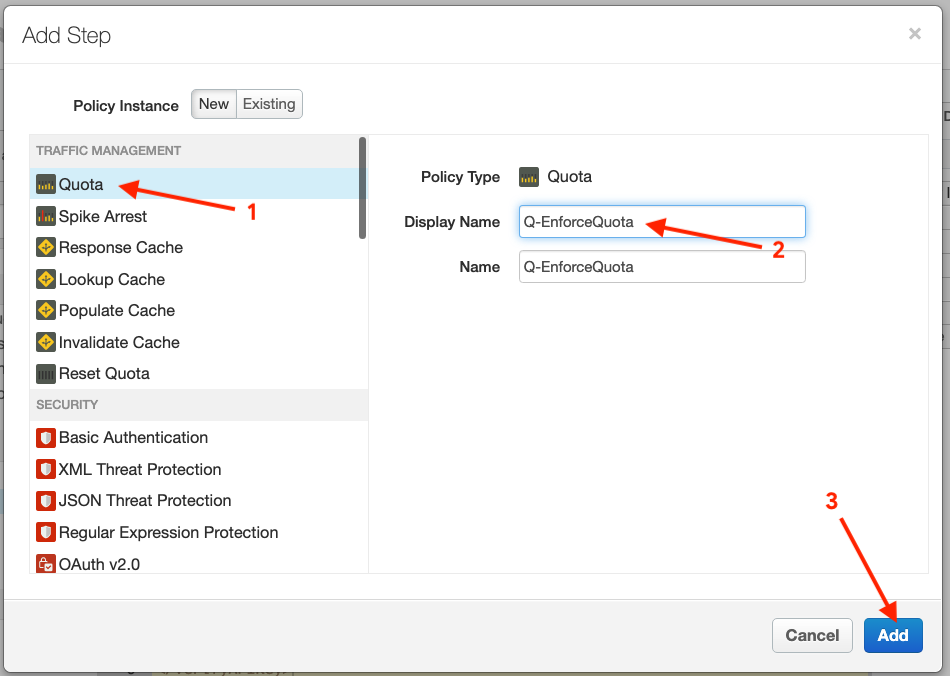

Open Q-EnforceQuota.xml and replace with the code as below and Save:
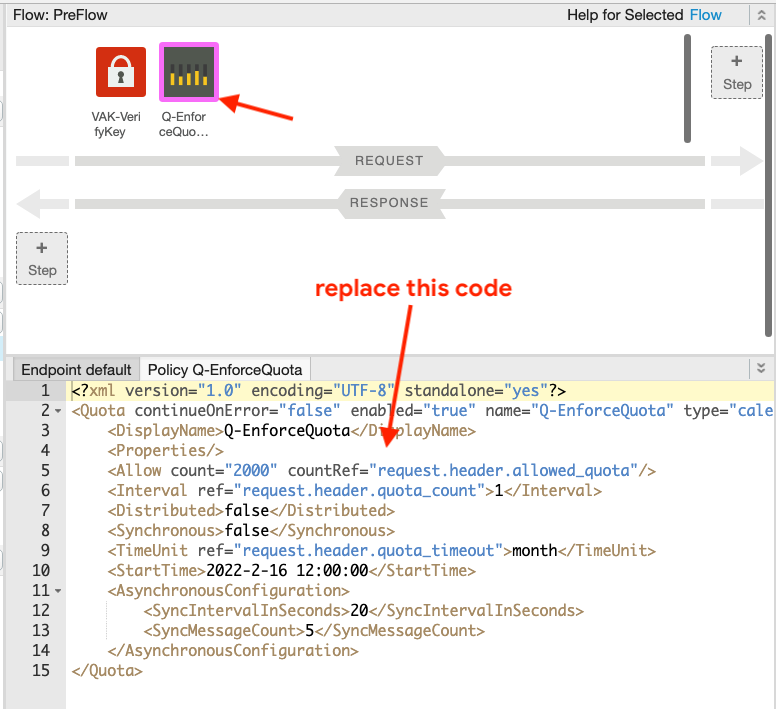

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<Quota name="Q-EnforceQuota" type="calendar">
  <UseQuotaConfigInAPIProduct stepName="VAK-VerifyKey">
      <DefaultConfig>
          <Allow>5</Allow>
          <Interval>1</Interval>
          <TimeUnit>hour</TimeUnit>
      </DefaultConfig>
  </UseQuotaConfigInAPIProduct>
  <StartTime>2022-01-01 00:00:00</StartTime>
</Quota>

Click Deploy > put Revision value > Environment: eval > put Service account > click Deploy

After the deployment succeeds, from the apigeex-test-vm virtual machine, use the following curl commands to test the API key functionality:

Fails (no API key):

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=de" -H "Content-Type:application/json" -d '{ "text": "Hello world!" }'

Fails (invalid API key):

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=de" -H "Content-Type:application/json" -H "Key: ABC123" -d '{ "text": "Hello world!" }'

Succeeds (when KEY variable is set to a valid API key KEY=REPLACEWITHVALIDKEY):

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=de" -H "Content-Type:application/json" -H "Key: $KEY" -d '{ "text": "Hello world!" }'



> **Task 4**

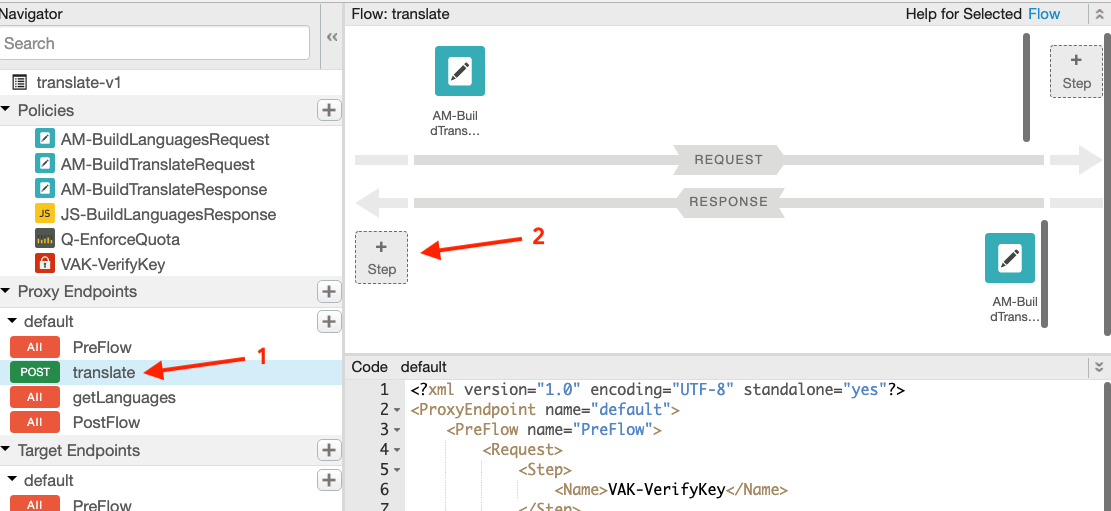



In Proxy endpoints > default > translate > click + to Add policy step
Click Select policy >  Create new policy
Select Message Logging as the Policy type > add ML-LogTranslation in Name and Display Name > Create
Select ML-LogTranslation > Add
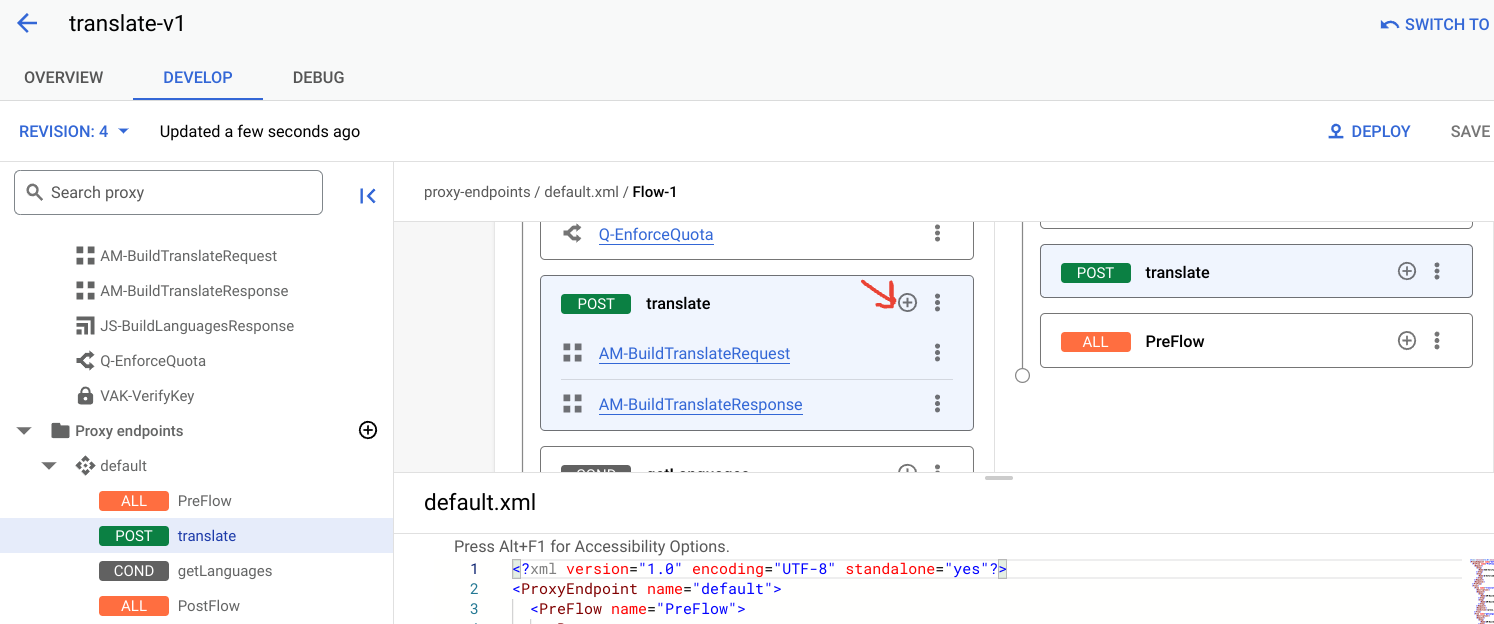
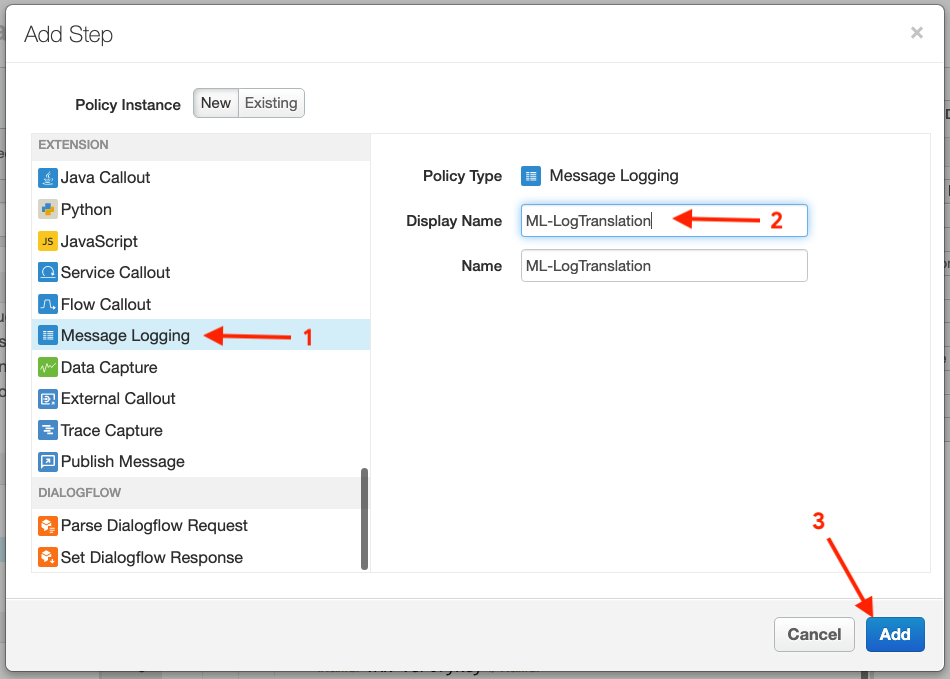

In ML-LogTranslation.xml, replace with the code as below and Save:
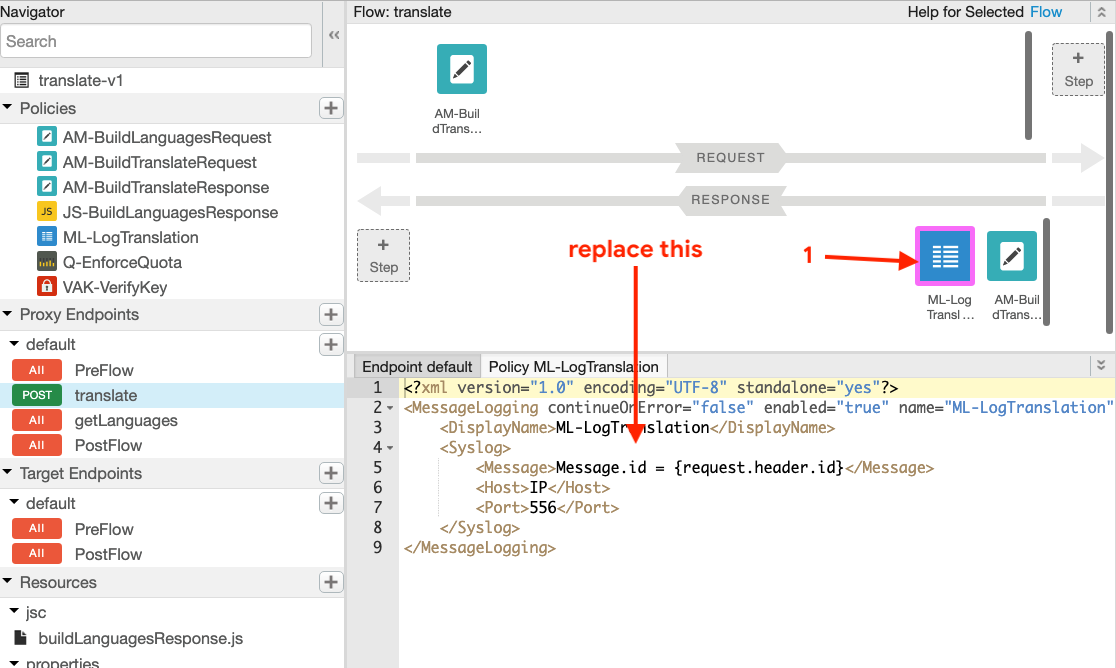

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<MessageLogging name="ML-LogTranslation">
  <CloudLogging>
      <LogName>projects/{organization.name}/logs/translate</LogName>
      <Message contentType="text/plain">{language}|{text}|{translated}</Message>
  </CloudLogging>
</MessageLogging>

Click Deploy > put Revision value > Environment: eval > put Service account > click Deploy


In GCP console > search Logging.
In Logs Explorer dashboard, use the query logName : "translate" to see only the translated logs.
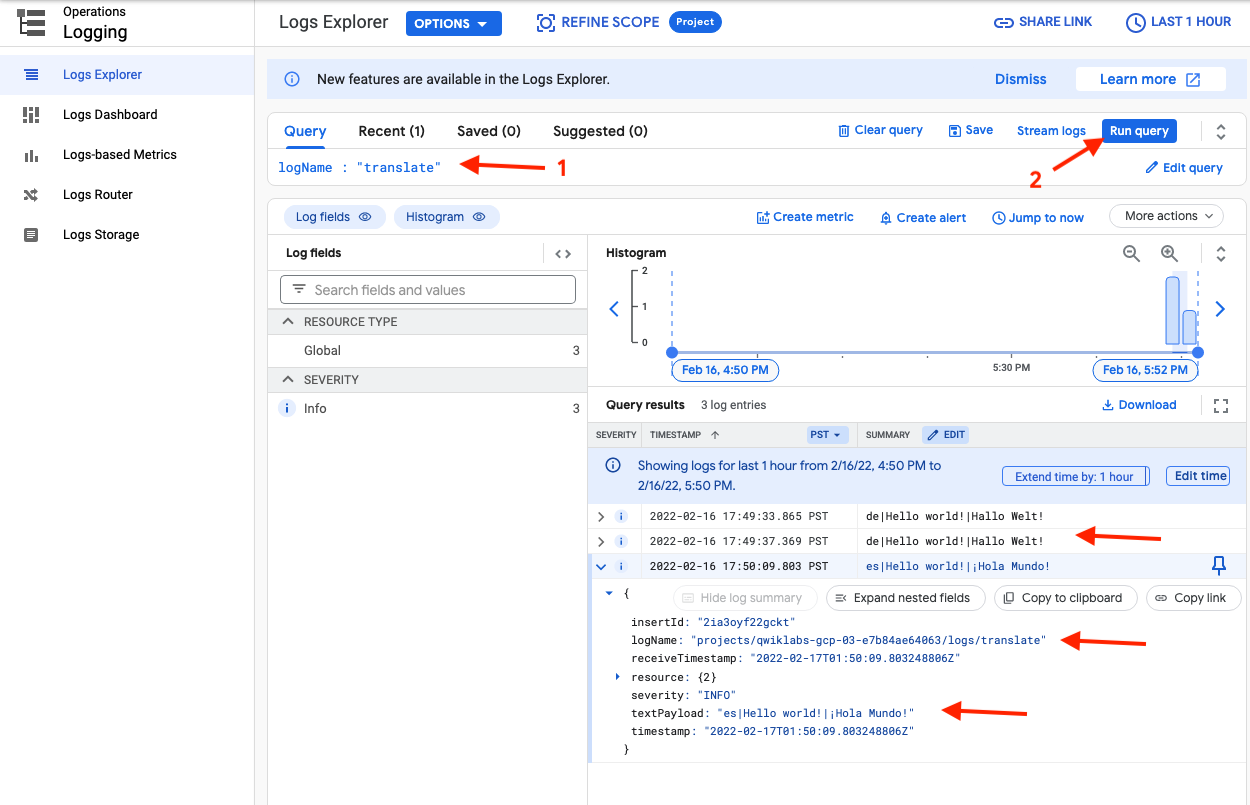

Once the MessageLogging policy has been successfully added, use the following curl command in SSH terminal:

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=de" -H "Content-Type:application/json" -H "Key: $KEY" -d '{ "text": "Hello world!" }'



> **Task 5**



Add Policy Step in translate (Request PreFlow) by clicking on ‘+’
Click on Select policy > Create New Policy
Select Assign Message in Policy type and put AM-BuildErrorResponse in Name and Display Name > Create
Select AM-BuildErrorResponse > Add

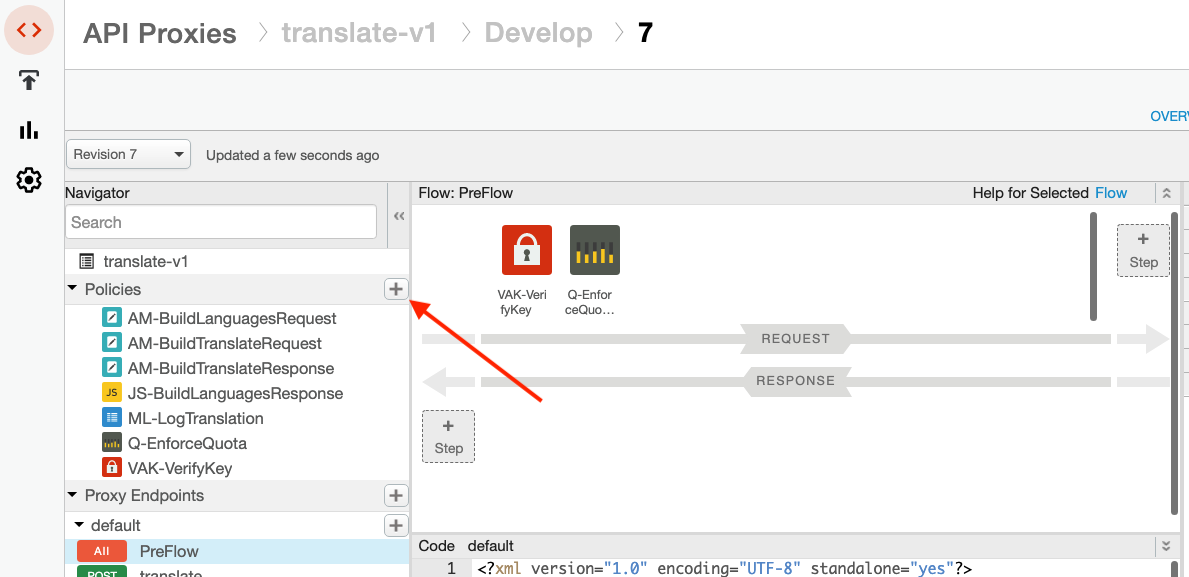
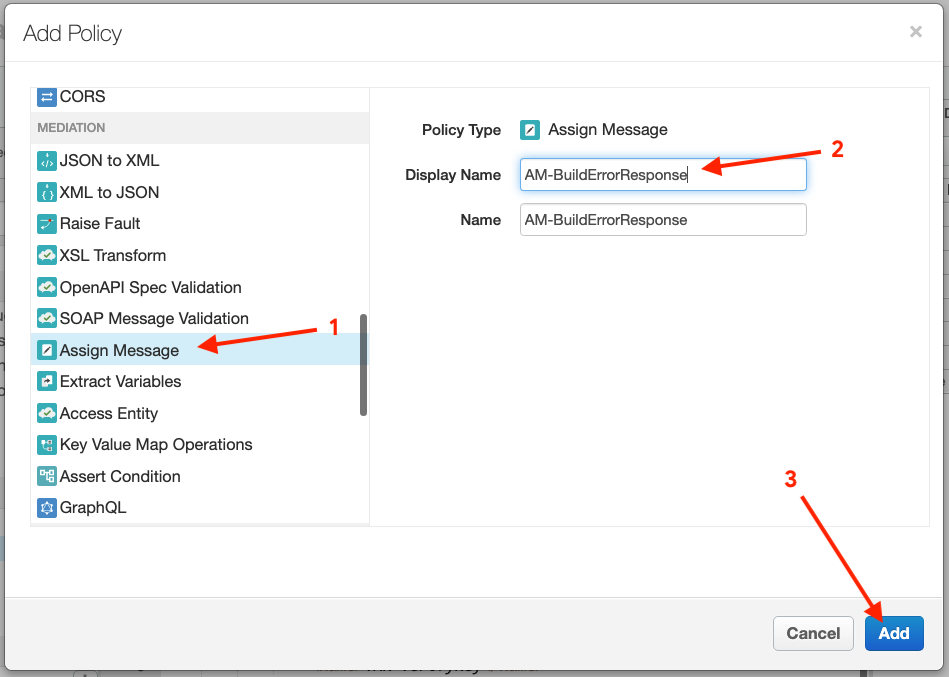



In AM-BuildErrorResponse.xml, replace with the code as given below and Save
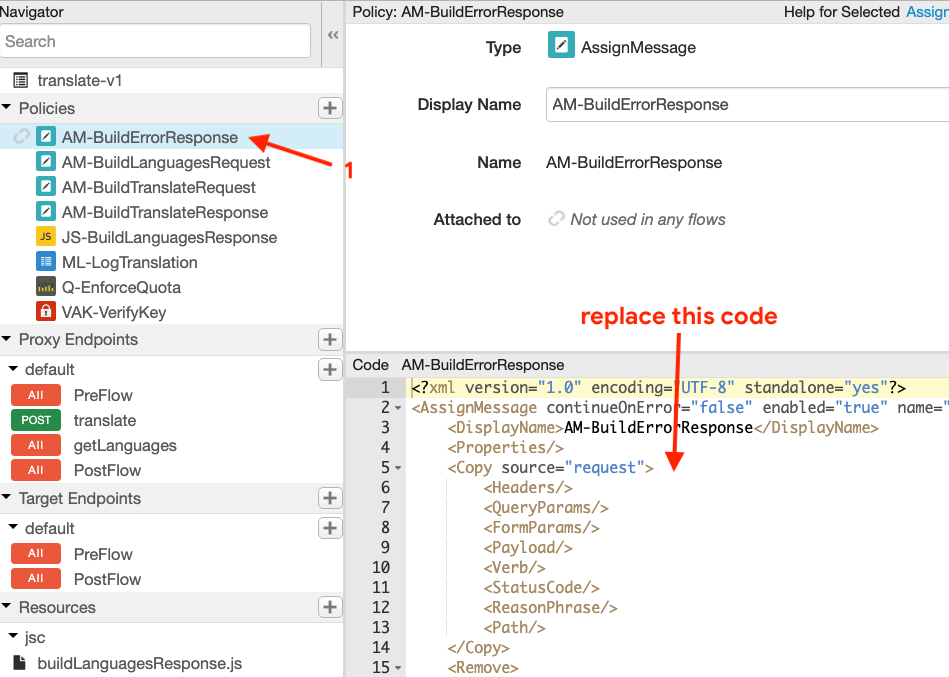

In [ ]:
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<AssignMessage name="AM-BuildErrorResponse">
  <Set>
      <Payload contentType="application/json">{ "error": "Invalid request. Verify the lang query parameter." }</Payload>
  </Set>
</AssignMessage>

Now under Target endpoints > default.xml add the highlighted text as given below and Save.
(make sure it is the TargetEndpoint, not the ProxyEndpoint).

In [ ]:
<TargetEndpoint name="default">
  <FaultRules>
      <FaultRule name="invalidInput">
          <Step>
              <Name>AM-BuildErrorResponse</Name>
          </Step>
          <Condition>fault.name == "ErrorResponseCode"</Condition>
      </FaultRule>
  </FaultRules>
  <PreFlow name="PreFlow">
      <Request/>
      <Response/>
  </PreFlow>

Click Deploy > put Revision value > Environment: eval > put Service account > click Deploy


After the deployment succeeds, enter the below commands in apigeex-test vm SSH terminal:

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=de" -H "Content-Type:application/json" -H "Key: $KEY" -d '{ "text": "Hello world!" }'

An invalid language query parameter like this should return the rewritten error message:

In [ ]:
curl -i -k -X POST "https://eval.example.com/translate/v1?lang=invalid" -H "Content-Type:application/json" -H "Key: $KEY" -d '{ "text": "Hello world!" }'